In [1]:
####################
# IMPORT LIBRARIES #
####################

import os
import xml.etree.ElementTree as ET
from lxml import etree
from collections import defaultdict, Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from typing import List, Dict, Union
import networkx as nx
from tqdm.notebook import tqdm
import powerlaw
from scipy.stats import linregress
import seaborn as sns
from networkx.algorithms import bipartite
import community as community_louvain
from sklearn.preprocessing import MultiLabelBinarizer

plt.style.use('seaborn-v0_8')

# Data extraction

In [ ]:
"""
From original XML post file extract useful fields.
"""

remove_columns = {'Body', 'Title', 'ContentLicense', 'ClosedDate', 'LastActivityDate'}
input_file = r'D:\Download\DDMCS\Posts.xml'
output_file = r'D:\Download\DDMCS\Posts_light.xml'

class TqdmFile:
    def __init__(self, f, total):
        self.f = f
        self.tqdm = tqdm(total=total, unit='B', unit_scale=True, desc="Processing XML")
    def read(self, size):
        data = self.f.read(size)
        self.tqdm.update(len(data))
        return data
    def __getattr__(self, attr):
        return getattr(self.f, attr)
    def close(self):
        self.tqdm.close()
        return self.f.close()

total_size = os.path.getsize(input_file)

with open(input_file, 'rb') as f:
    tf = TqdmFile(f, total_size)
    context = etree.iterparse(tf, events=("end",), tag="row")
    
    with etree.xmlfile(output_file, encoding="UTF-8") as xf:
        with xf.element("posts"):

            for event, row in context:

                for attr in remove_columns:
                    row.attrib.pop(attr, None)

                xf.write(row)
                row.clear()

                while row.getprevious() is not None:
                    del row.getparent()[0]

    tf.close()

Processing XML: 100%|██████████| 104G/104G [32:56<00:00, 52.4MB/s]   


In [ ]:
"""
From original XML comments file extract useful fields.
"""

remove_columns = {'ContentLicense', 'Score', 'Text'}
input_file = r'D:\Download\DDMCS\Comments.xml'
output_file = r'D:\Download\DDMCS\Comments_light.xml'

total_size = os.path.getsize(input_file)

with open(input_file, 'rb') as f:
    tf = TqdmFile(f, total_size)
    context = etree.iterparse(tf, events=("end",), tag="row")
    
    with etree.xmlfile(output_file, encoding="UTF-8") as xf:
        with xf.element("posts"):
            for event, row in context:

                for attr in remove_columns:
                    row.attrib.pop(attr, None)

                xf.write(row)
                row.clear()

                while row.getprevious() is not None:
                    del row.getparent()[0]

    tf.close()

Processing XML: 100%|██████████| 28.1G/28.1G [18:51<00:00, 24.9MB/s]


In [ ]:
"""
Extract questions char count, year and tags.
"""

data = []

with open(r'D:\Download\DDMCS\Posts.xml', 'rb') as f:
    total_lines = sum(1 for _ in f)

for event, elem in tqdm(ET.iterparse(r'D:\Download\DDMCS\Posts.xml', events=('end',)), total=total_lines):
    if elem.tag == 'row':
        post_type_id = elem.attrib.get('PostTypeId')

        if post_type_id == '1':  # Only questions
            body = elem.attrib.get('Body', '')
            creation_date = elem.attrib.get('CreationDate')
            tags = elem.attrib.get('Tags', '')

            if creation_date:
                year = datetime.fromisoformat(creation_date).year
                char_count = len(body)
                data.append({'Year': year, 'CharCount': char_count, 'Tags': tags})

        elem.clear()

df = pd.DataFrame(data)

print(df.head())

with open("complexity.pkl", "wb") as file:
    pickle.dump(df, file)

100%|█████████▉| 59311039/59311048 [56:52<00:00, 17382.97it/s]  


   Year  CharCount                                               Tags
0  2008       3411  <performance><algorithm><language-agnostic><un...
1  2008       3290                      <c#><sql><vb.net><ascii><hex>
2  2008       1960                 <apache-flex><actionscript-3><air>
3  2008        255  <algorithm><language-agnostic><colors><color-s...
4  2008       1738                                    <database><xsd>


In [ ]:
"""
Divide data by years.
"""

def extract_posts_in_timespan(
    xml_file: str,
    start_date: str,
    end_date: str,
    as_dataframe: bool = True
) -> Union[pd.DataFrame, List[Dict]]:
    
    start_dt = datetime.fromisoformat(start_date)
    end_dt = datetime.fromisoformat(end_date)

    fields = ["Id", "PostTypeId", "CreationDate", "OwnerUserId", "ParentId", "Tags", "Score"]
    results = []

    context = ET.iterparse(xml_file, events=('end',))
    for _, elem in context:
        if elem.tag != "row":
            continue

        creation_str = elem.attrib.get("CreationDate")
        if not creation_str:
            elem.clear()
            continue

        try:
            creation_date = datetime.fromisoformat(creation_str[:10])
        except ValueError:
            elem.clear()
            continue

        if creation_date > end_dt:
            break  # early exit since the file is ordered

        if creation_date >= start_dt:
            post = {f: elem.attrib.get(f) for f in fields}
            results.append(post)

        elem.clear()

    return pd.DataFrame(results) if as_dataframe else results

###

all_data = []

for year in range(2009, 2024+1):
    
    data = extract_posts_in_timespan(xml_file=r"D:\Download\DDMCS\Posts_light.xml",
                                     start_date=str(year)+"-01-01",
                                     end_date=str(year)+"-12-31",
                                     as_dataframe=True)

    with open(str(year)+".pkl", "wb") as file:
        pickle.dump(data, file)

    all_data.append((year, data))

In [ ]:
"""
Get comment data.
"""

def extract_posts_in_timespan(
    xml_file: str,
    start_date: str,
    end_date: str,
    as_dataframe: bool = True
) -> Union[pd.DataFrame, List[Dict]]:
    
    start_dt = datetime.fromisoformat(start_date)
    end_dt = datetime.fromisoformat(end_date)

    fields = ["Id", "PostId", "CreationDate", "UserId"]
    results = []

    context = ET.iterparse(xml_file, events=('end',))
    for _, elem in context:
        if elem.tag != "row":
            continue

        creation_str = elem.attrib.get("CreationDate")
        if not creation_str:
            elem.clear()
            continue

        try:
            creation_date = datetime.fromisoformat(creation_str[:10])
        except ValueError:
            elem.clear()
            continue

        if creation_date >= start_dt and creation_date <= end_dt:
            post = {f: elem.attrib.get(f) for f in fields}
            results.append(post)

        elem.clear()

    return pd.DataFrame(results) if as_dataframe else results

###

all_comments_data = []

for year in range(2009, 2024+1):

    data = extract_posts_in_timespan(xml_file=r"D:\Download\DDMCS\Comments_light.xml",
                                        start_date=str(year)+"-01-01",
                                        end_date=str(year)+"-12-31",
                                        as_dataframe=True)

    with open("comments_"+str(year)+".pkl", "wb") as file:
        pickle.dump(data, file)

    all_comments_data.append(data)

In [ ]:
"""
Build edge lists from all data (posts and comments).
Then build graphs from edge lists.
"""

def get_edges(post_data_path, comments_data_path):
    with open(post_data_path, 'rb') as f:
        post_data = pickle.load(f)

    with open(comments_data_path, 'rb') as f:
        comments_data = pickle.load(f)

    merged_comments = pd.merge(post_data, comments_data, left_on='Id', right_on='PostId', how='inner')
    merged_comments = merged_comments[["OwnerUserId", "UserId"]]
    merged_comments = merged_comments.rename(columns={"OwnerUserId" : "1", "UserId": "2"})

    type1_data = post_data[post_data["PostTypeId"] == "1"]
    type2_data = post_data[post_data["PostTypeId"] == "2"]

    merged_posts = pd.merge(type1_data, type2_data, left_on='Id', right_on='ParentId', how='inner')
    merged_posts = merged_posts[["OwnerUserId_x", "OwnerUserId_y"]]
    merged_posts = merged_posts.rename(columns={"OwnerUserId_x": "1", "OwnerUserId_y": "2"})

    stacked_df = pd.concat([merged_posts, merged_comments], axis=0)
    stacked_df = stacked_df.apply(pd.to_numeric, errors='coerce').astype('Int64')

    # Sort each row so that smaller ID comes first
    stacked_df['1'] = stacked_df.min(axis=1)
    stacked_df['2'] = stacked_df.max(axis=1)

    # Drop duplicates based on sorted endpoints
    df_unique = stacked_df.drop_duplicates()

    return df_unique

###

all_data = []

for year in range(2009, 2024+1):
    print(year)
    df_unique = get_edges(str(year)+".pkl", "comments_"+str(year)+".pkl")
    all_data.append(df_unique)

all_graphs = []

for data in all_data:
    G = nx.Graph()
    G.add_edges_from(data.values)
    all_graphs.append(G)

with open('new_all_graphs.pkl', 'wb') as f:
    pickle.dump(all_graphs, f)

# Graphs of questions and answers

In [ ]:
"""
Load from already computed. 
"""

all_data = []

for year in range(2009, 2024+1):
    
    with open(str(year)+'.pkl', 'rb') as f:
        data = pickle.load(f)

    all_data.append(data)

In [ ]:
"""
Convert year data into year graph. In those networks there are edges between two users if a users answered the question of another user.
"""

def get_user_user_graph(df):
    question_owners = df[df["PostTypeId"] == "1"]
    question_owners = question_owners[["Id", "OwnerUserId"]]
    question_owner_dict = dict(zip(question_owners["Id"], question_owners["OwnerUserId"]))

    answers = df[df["PostTypeId"] == "2"]

    G = nx.DiGraph()
    n = df.shape[0]

    for answer in tqdm(answers.itertuples(index=False), total=n):
        question_id = answer.ParentId
        answerer = answer.OwnerUserId

        question_owner = question_owner_dict.get(question_id)

        if question_owner and answerer and question_owner != answerer:
            G.add_edge(answerer, question_owner)

        # Stop after n iterations
        n -= 1
        if n == 0:
            break

    G = G.to_undirected()

    return G

all_graphs = []

for data in all_data:
    graph = get_user_user_graph(data)
    all_graphs.append(graph)

# Bipartite networks

In [ ]:
"""
Get bipartite networks
"""

def build_bipartite_user_question_graph(df):
    B = nx.Graph()

    questions = df[df["PostTypeId"] == "1"]
    for _, row in questions.iterrows():
        user = "usr_"+row["OwnerUserId"]
        question_id = "qst_"+row["Id"]

        B.add_node(user, bipartite="user")
        B.add_node(question_id, bipartite="question")
        B.add_edge(user, question_id)

    answers = df[df["PostTypeId"] != "1"]
    for _, row in answers.iterrows():

        if pd.notnull(row["OwnerUserId"]) and pd.notnull(row["ParentId"]):
            user = "usr_"+row["OwnerUserId"]
            parent_id = "qst_"+row["ParentId"]

            if parent_id in B:
                B.add_node(user, bipartite="user")
                B.add_edge(user, parent_id)

    largest_cc = max(nx.connected_components(B), key=len)

    return B.subgraph(largest_cc)

graph_1 = build_bipartite_user_question_graph(all_data[-1]) #2024
graph_2 = build_bipartite_user_question_graph(all_data[-3]) # 2022
graph_3 = build_bipartite_user_question_graph(all_data[-5]) #2020
graph_4 = build_bipartite_user_question_graph(all_data[1]) #2009
graph_5 = build_bipartite_user_question_graph(all_data[-4]) #2021
graph_6 = build_bipartite_user_question_graph(all_data[-6]) # 2019

with open('bipartite_2024.pkl', 'wb') as f:
    pickle.dump(graph, f)

with open('bipartite_2022.pkl', 'wb') as f:
    pickle.dump(graph_2, f)

with open('bipartite_2020.pkl', 'wb') as f:
    pickle.dump(graph_3, f)

with open('bipartite_2009.pkl', 'wb') as f:
    pickle.dump(graph_4, f)

with open('bipartite_2021.pkl', 'wb') as f:
    pickle.dump(graph_5, f)

with open('bipartite_2019.pkl', 'wb') as f:
    pickle.dump(graph_6, f)

In [ ]:
"""
Load bipartite networks.
"""

with open('bipartite_2024.pkl', 'rb') as f:
    graph_1 = pickle.load(f)

with open('bipartite_2022.pkl', 'rb') as f:
    graph_2 = pickle.load(f)

with open('bipartite_2020.pkl', 'rb') as f:
    graph_3 = pickle.load(f)

with open('bipartite_2009.pkl', 'rb') as f:
    graph_4 = pickle.load(f)

with open('bipartite_2021.pkl', 'rb') as f:
    graph_5 = pickle.load(f)

with open('bipartite_2019.pkl', 'rb') as f:
    graph_6 = pickle.load(f)

In [ ]:
users_1 = {n for n, d in graph.nodes(data=True) if d['bipartite'] == 'user'}
user_projection_1 = bipartite.projected_graph(graph, users_1)

users_2 = {n for n, d in graph_2.nodes(data=True) if d['bipartite'] == 'user'}
user_projection_2 = bipartite.projected_graph(graph_2, users_2)

users_3 = {n for n, d in graph_3.nodes(data=True) if d['bipartite'] == 'user'}
user_projection_3 = bipartite.projected_graph(graph_3, users_3)

users_4 = {n for n, d in graph_4.nodes(data=True) if d['bipartite'] == 'user'}
user_projection_4 = bipartite.projected_graph(graph_4, users_4)

users_5 = {n for n, d in graph_5.nodes(data=True) if d['bipartite'] == 'user'}
user_projection_5 = bipartite.projected_graph(graph_5, users_5)

users_6 = {n for n, d in graph_6.nodes(data=True) if d['bipartite'] == 'user'}
user_projection_6 = bipartite.projected_graph(graph_6, users_6)

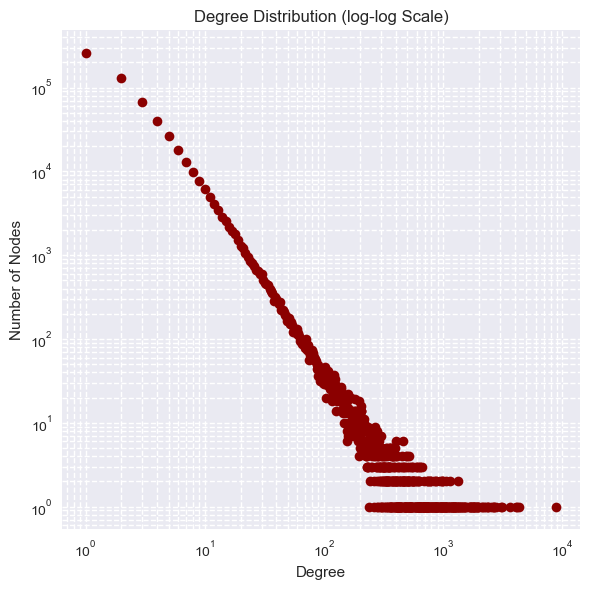

In [ ]:
"""
Plot degree distribution.
"""

degrees = [degree for _, degree in user_projection_5.degree()]

degree_count = {}
for deg in degrees:
    degree_count[deg] = degree_count.get(deg, 0) + 1

deg, cnt = zip(*sorted(degree_count.items()))

plt.figure(figsize=(6, 6))
plt.loglog(deg, cnt, marker='o', linestyle='None', color='darkred')
plt.title("Degree Distribution (log-log Scale)")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Graphs of questions, answers and comments

In [ ]:
"""
Load posts data
"""

all_posts_data = []

for year in range(2009, 2024+1):
    
    with open(str(year)+'.pkl', 'rb') as f:
        data = pickle.load(f)

    all_posts_data.append(data)

In [ ]:
"""
Get amount of questions, answers and comments per year.
"""

for year in range(2009, 2024+1):
    with open(str(year)+'.pkl', 'rb') as f:
        data = pickle.load(f)

        print(data[data["PostTypeId"] == "1"].shape)
        print(data[data["PostTypeId"] == "2"].shape)

for year in range(2009, 2024+1):
    
    with open("comments_"+str(year)+'.pkl', 'rb') as f:
        data = pickle.load(f)

        print(data.shape)

In [3]:
"""
Load graphs
"""
    
with open("new_all_graphs.pkl", 'rb') as f:
    all_graphs = pickle.load(f)

In [ ]:
"""
Get graph infos
"""

i=0

for G in all_graphs:
    print(2009+i)
    i += 1
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    print("Is connected:", nx.is_connected(G))
    print("Number of connected components:", nx.number_connected_components(G))

    total_nodes = G.number_of_nodes()
    connected_components = list(nx.connected_components(G))
    largest_cc_size = max(len(comp) for comp in connected_components)
    percentage = (largest_cc_size / total_nodes) * 100

    print(f"Percentage of nodes in the largest connected component: {percentage:.2f}%")

2009
Number of nodes: 69961
Number of edges: 578044
Is connected: False
Number of connected components: 4696
Percentage of nodes in the largest connected component: 92.49%
2010
Number of nodes: 168666
Number of edges: 993317
Is connected: False
Number of connected components: 17626
Percentage of nodes in the largest connected component: 87.60%
2011
Number of nodes: 299840
Number of edges: 1626626
Is connected: False
Number of connected components: 32683
Percentage of nodes in the largest connected component: 87.36%
2012
Number of nodes: 433798
Number of edges: 2145569
Is connected: False
Number of connected components: 53091
Percentage of nodes in the largest connected component: 86.41%
2013
Number of nodes: 607997
Number of edges: 2610528
Is connected: False
Number of connected components: 90960
Percentage of nodes in the largest connected component: 83.59%
2014
Number of nodes: 702180
Number of edges: 2611716
Is connected: False
Number of connected components: 125626
Percentage of no

In [ ]:
def fit_power_law(G, xmin=None):
    degree_sequence = [d for _, d in G.degree()]

    fit = powerlaw.Fit(degree_sequence, discrete=True, xmin=xmin)

    alpha = fit.power_law.alpha
    xmin = fit.power_law.xmin

    D = fit.power_law.D  # KS statistic

    print(f"Fitted power-law exponent (alpha): {alpha:.4f}")
    print(f"Estimated xmin: {xmin}")
    print(f"Kolmogorov-Smirnov statistic D: {D:.4f}")

    R, p = fit.distribution_compare('power_law', 'lognormal')

    print("Likelihood:", R)
    print("p-value:", p)

    n_tail = sum(data_i >= xmin for data_i in fit.data)
    print(f"Tail size: {n_tail}")

    plt.figure(figsize=(6, 6))
    # Optional: plot
    fit.plot_pdf(label='Empirical Data')
    fit.power_law.plot_pdf(label='Power-law Fit')
    plt.legend()
    plt.show()

    return alpha

Fitted power-law exponent (alpha): 2.2752
Estimated xmin: 13.0
Kolmogorov-Smirnov statistic D: 0.0170
Likelihood: -0.8811878115156713
p-value: 0.3059166246777275
Tail size: 5945


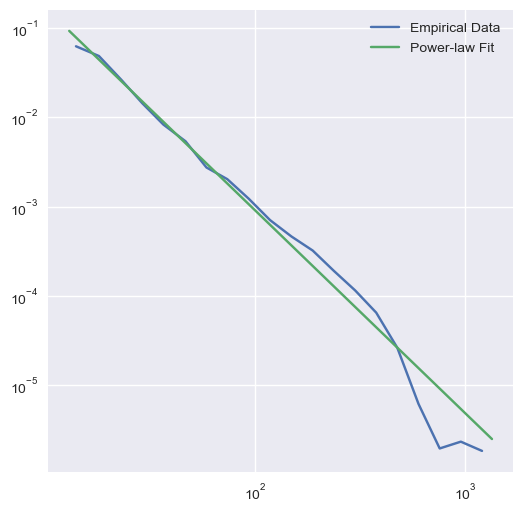

In [153]:
# 2024
fit_power_law(all_graphs[-1], 13);

Fitted power-law exponent (alpha): 2.3019
Estimated xmin: 13.0
Kolmogorov-Smirnov statistic D: 0.0183
Likelihood: -0.23822995523044987
p-value: 0.14665391744769266
Tail size: 11356


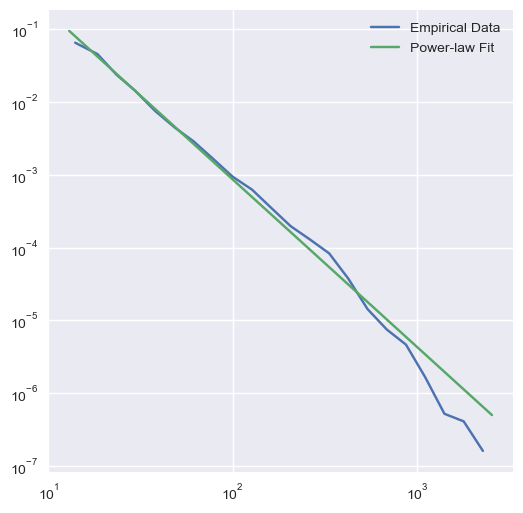

In [151]:
# 2023
fit_power_law(all_graphs[-2], 13);

Fitted power-law exponent (alpha): 2.3574
Estimated xmin: 13.0
Kolmogorov-Smirnov statistic D: 0.0168
Likelihood: -0.18956049428467114
p-value: 0.29611786789066263
Tail size: 21990


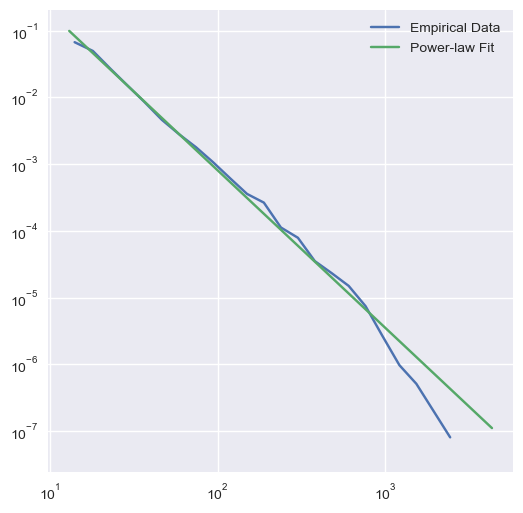

In [146]:
# 2022
fit_power_law(all_graphs[-3], 13);

Fitted power-law exponent (alpha): 2.3780
Estimated xmin: 12.0
Kolmogorov-Smirnov statistic D: 0.0146
Likelihood: -0.22568186503052878
p-value: 0.4327645667613561
Tail size: 31562


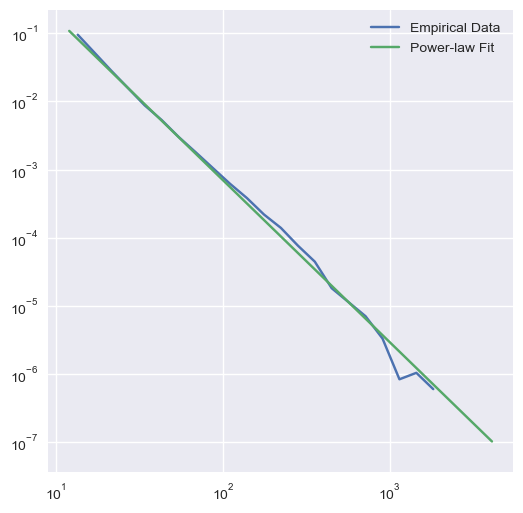

In [147]:
# 2021
fit_power_law(all_graphs[-4], 12);

Fitted power-law exponent (alpha): 2.3882
Estimated xmin: 12.0
Kolmogorov-Smirnov statistic D: 0.0063
Likelihood: -0.6249339029143659
p-value: 0.30100978538998424
Tail size: 43654


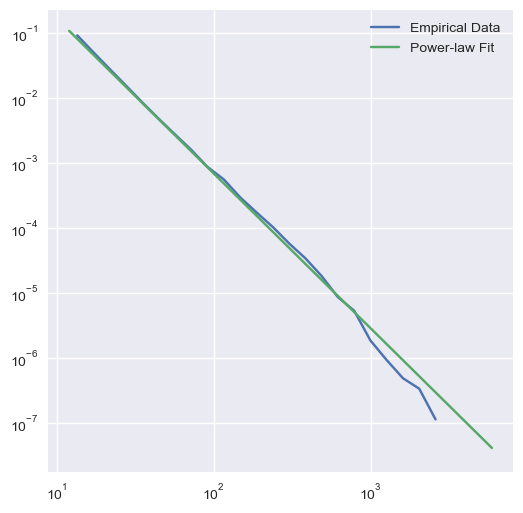

In [148]:
# 2020
fit_power_law(all_graphs[-5], 12);

Fitted power-law exponent (alpha): 2.6687
Estimated xmin: 100.0
Kolmogorov-Smirnov statistic D: 0.0319
Likelihood: -29.40306790109966
p-value: 7.082424644275468e-06
Tail size: 4726


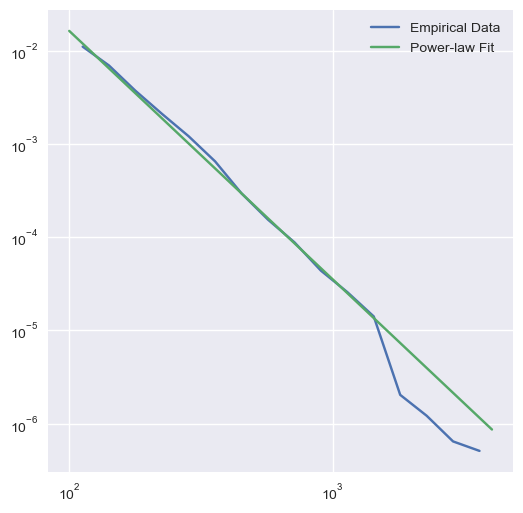

In [37]:
# 2010
fit_power_law(all_graphs[2], xmin=100);

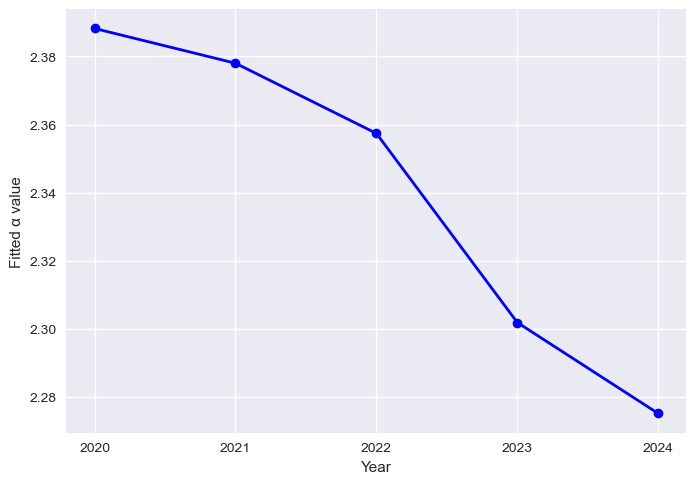

In [ ]:
"""
Plot fitted alpha value over time.
"""

x = [2020, 2021, 2022, 2023, 2024]
y = [2.3882, 2.3780, 2.3574, 2.3019, 2.2752]

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Fitted α value')

plt.xticks(x)
plt.grid(True)


plt.show()

In [ ]:
"""
Degree difference plot.
"""

def plot_degree_diff_with_new_user_overlay(G1, G2, years):
    import matplotlib.pyplot as plt
    import numpy as np

    users = set(G1.nodes).union(G2.nodes)
    finite_diffs = []
    g1_only_diffs = []
    g2_only_diffs = []
    g1_only = 0
    g2_only = 0

    for user in users:
        if user in G1 and user in G2:
            diff = G2.degree(user) - G1.degree(user)
            finite_diffs.append(diff)
        elif user in G1:
            deg = G1.degree(user)
            g1_only += 1
            g1_only_diffs.append(-deg)
        elif user in G2:
            deg = G2.degree(user)
            g2_only += 1
            g2_only_diffs.append(deg)

    plt.figure(figsize=(12, 6))

    all_diffs = finite_diffs + g1_only_diffs + g2_only_diffs
    g1_diffs = finite_diffs + g1_only_diffs
    g2_diffs = finite_diffs + g2_only_diffs
    max_abs = max(abs(min(all_diffs, default=0)), abs(max(all_diffs, default=0)))

    bin_range = (-max_abs, max_abs)
    bins = np.linspace(*bin_range, 51)

    
    plt.hist(g1_diffs, bins=bins, color='crimson', edgecolor='black', alpha=0.3,
             label='G2-only users (overlayed)', zorder=1)

    vals2 = plt.hist(g2_diffs, bins=bins, color='limegreen', edgecolor='black', alpha=0.3,
             label='G2-only users (overlayed)', zorder=1)

    vals = plt.hist(finite_diffs, bins=bins, color='steelblue', edgecolor='black',
             label='G1 & G2 users', zorder=2)

    plt.yscale('log')
    plt.xlabel("Degree Difference ("+str(years[1])+" - "+str(years[0])+")")
    plt.ylabel("Number of Users (log-scale)")

    min_bin = bins[0]
    max_bin = bins[-1]
    offset = (max_bin - min_bin) * 0.05 or 1

    plt.bar(min_bin - 2*offset, g1_only, width=offset, color='crimson', label='G1 only (−∞)', zorder=3)
    plt.bar(max_bin + offset, g2_only, width=offset, color='limegreen', label='G2 only (+∞)', zorder=3)


    plt.tight_layout()
    plt.show()
    
    return g1_only, g2_only, list(zip(vals[1], vals[0])), list(zip(vals2[1], vals2[0]))

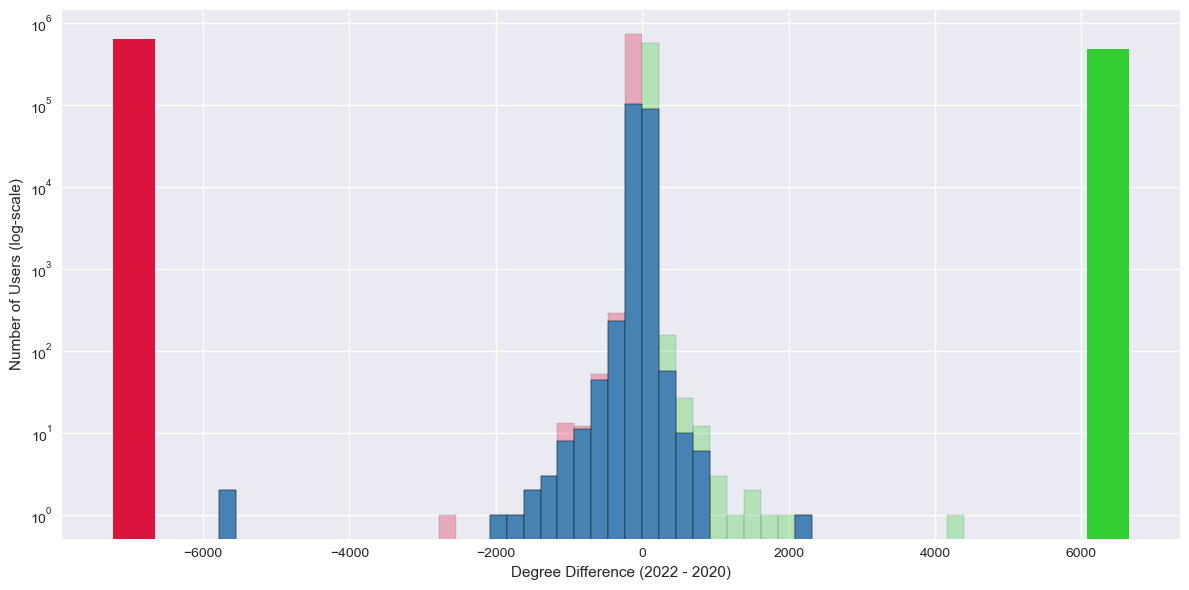

(640228,
 486315,
 [(-5785.0, 2.0),
  (-5553.6, 0.0),
  (-5322.2, 0.0),
  (-5090.8, 0.0),
  (-4859.4, 0.0),
  (-4628.0, 0.0),
  (-4396.6, 0.0),
  (-4165.2, 0.0),
  (-3933.8, 0.0),
  (-3702.4, 0.0),
  (-3471.0, 0.0),
  (-3239.6, 0.0),
  (-3008.2, 0.0),
  (-2776.7999999999997, 0.0),
  (-2545.4, 0.0),
  (-2314.0, 0.0),
  (-2082.6, 1.0),
  (-1851.1999999999998, 1.0),
  (-1619.8000000000002, 2.0),
  (-1388.3999999999996, 3.0),
  (-1157.0, 8.0),
  (-925.5999999999995, 11.0),
  (-694.1999999999998, 44.0),
  (-462.8000000000002, 233.0),
  (-231.39999999999964, 103061.0),
  (0.0, 89988.0),
  (231.40000000000055, 57.0),
  (462.8000000000002, 10.0),
  (694.1999999999998, 6.0),
  (925.6000000000004, 0.0),
  (1157.0, 0.0),
  (1388.4000000000005, 0.0),
  (1619.8000000000002, 0.0),
  (1851.1999999999998, 0.0),
  (2082.6000000000004, 1.0),
  (2314.0, 0.0),
  (2545.3999999999996, 0.0),
  (2776.800000000001, 0.0),
  (3008.2000000000007, 0.0),
  (3239.6000000000004, 0.0),
  (3471.0, 0.0),
  (3702.3999999

In [51]:
# 2022 - 2020
plot_degree_diff_with_new_user_overlay(all_graphs[-5], all_graphs[-3], (2020, 2022))

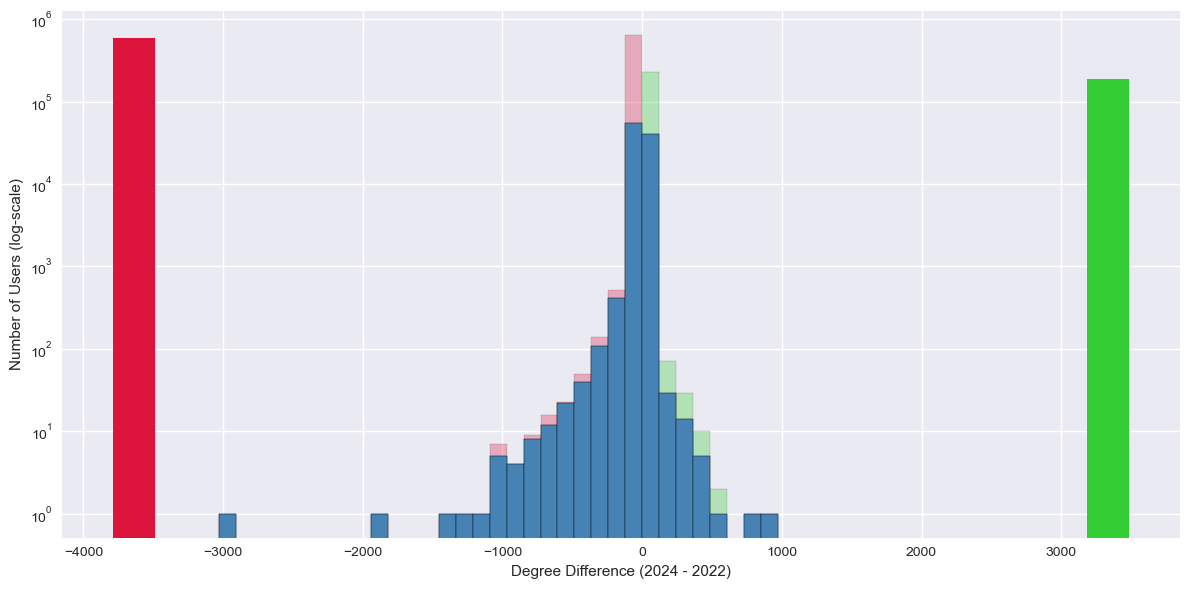

(584184,
 190386,
 [(-3032.0, 1.0),
  (-2910.72, 0.0),
  (-2789.44, 0.0),
  (-2668.16, 0.0),
  (-2546.88, 0.0),
  (-2425.6, 0.0),
  (-2304.3199999999997, 0.0),
  (-2183.04, 0.0),
  (-2061.76, 0.0),
  (-1940.48, 1.0),
  (-1819.2, 0.0),
  (-1697.92, 0.0),
  (-1576.6399999999999, 0.0),
  (-1455.36, 1.0),
  (-1334.08, 1.0),
  (-1212.8, 1.0),
  (-1091.52, 5.0),
  (-970.2399999999998, 4.0),
  (-848.96, 8.0),
  (-727.6799999999998, 12.0),
  (-606.4000000000001, 22.0),
  (-485.1199999999999, 40.0),
  (-363.84000000000015, 109.0),
  (-242.55999999999995, 409.0),
  (-121.27999999999975, 54612.0),
  (0.0, 40282.0),
  (121.2800000000002, 29.0),
  (242.55999999999995, 14.0),
  (363.84000000000015, 5.0),
  (485.1199999999999, 1.0),
  (606.4000000000001, 0.0),
  (727.6799999999998, 1.0),
  (848.96, 1.0),
  (970.2400000000002, 0.0),
  (1091.5200000000004, 0.0),
  (1212.8000000000002, 0.0),
  (1334.08, 0.0),
  (1455.3599999999997, 0.0),
  (1576.6400000000003, 0.0),
  (1697.92, 0.0),
  (1819.19999999999

In [52]:
# 2024 - 2022
plot_degree_diff_with_new_user_overlay(all_graphs[-3], all_graphs[-1], (2022, 2024))

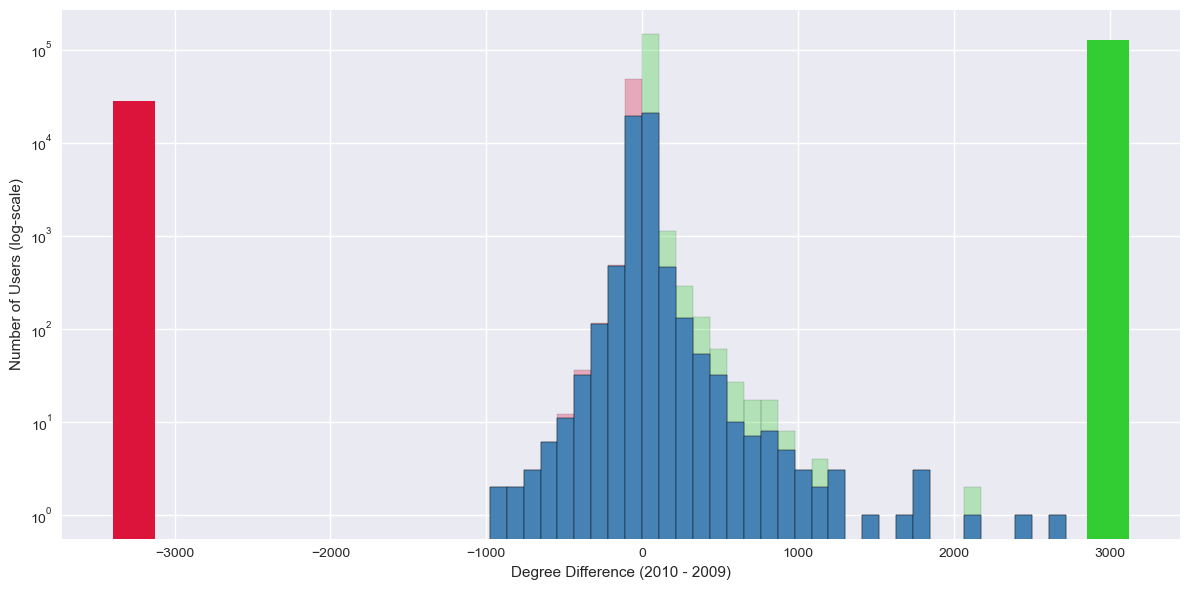

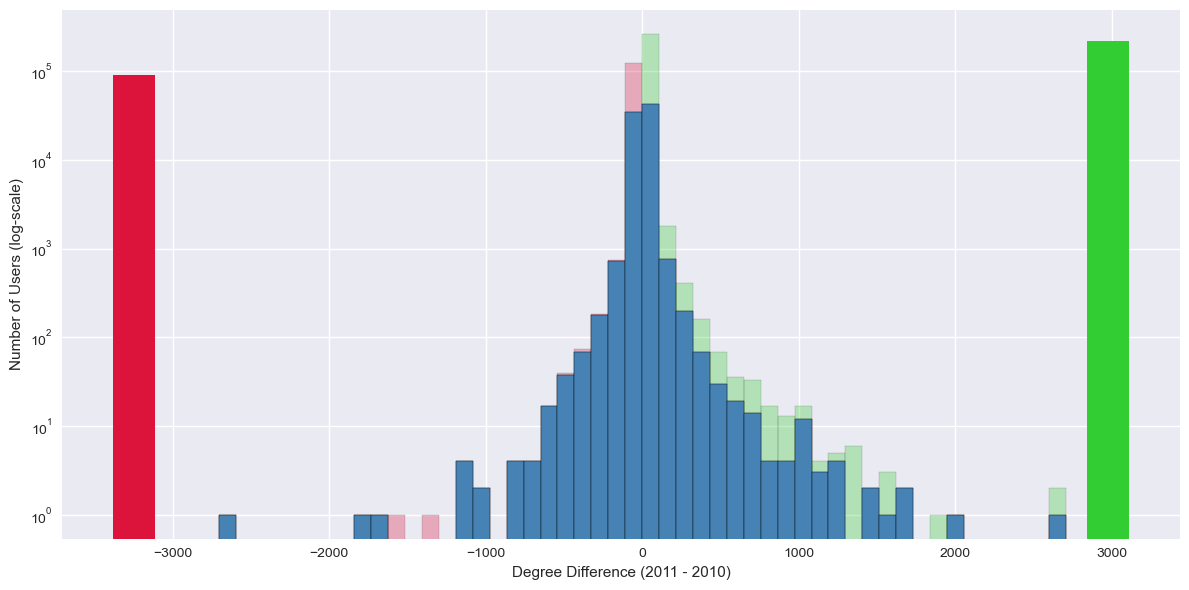

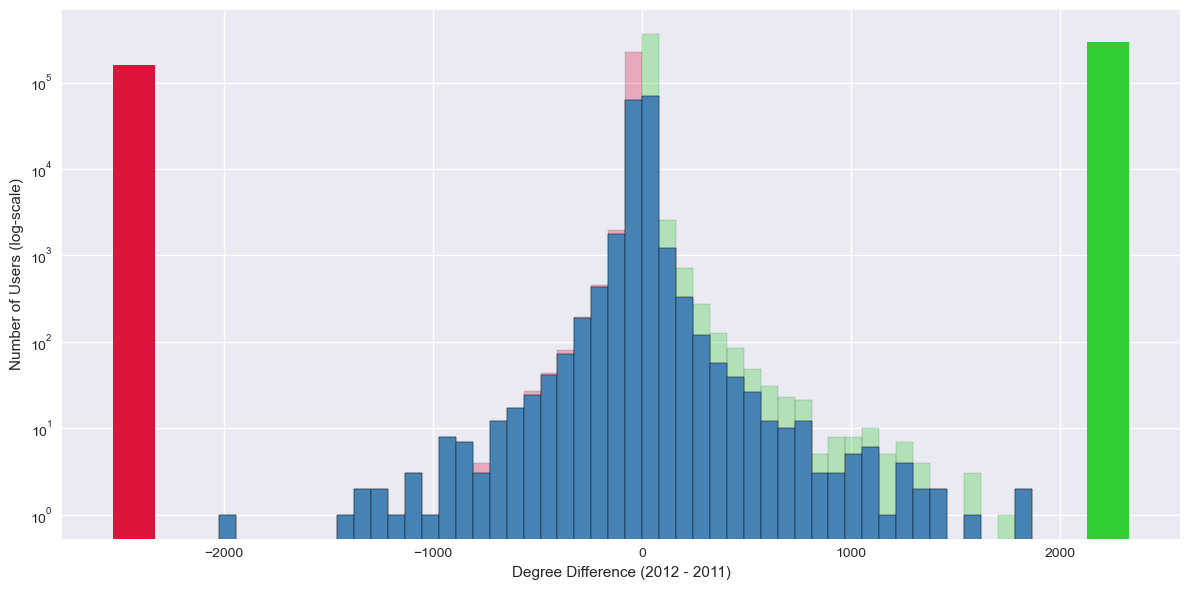

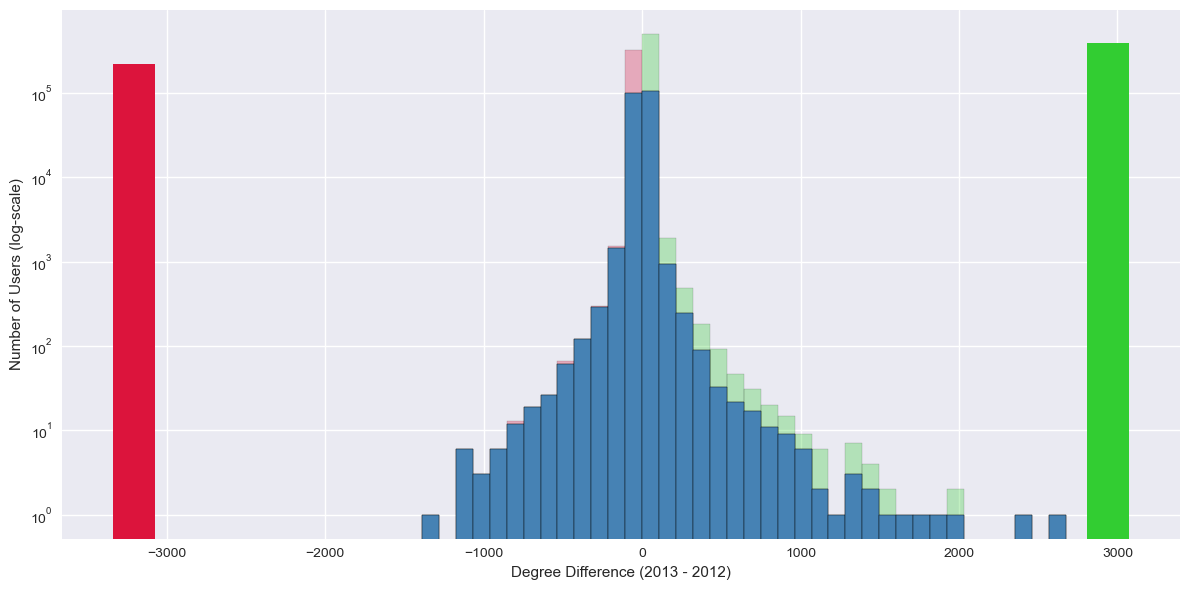

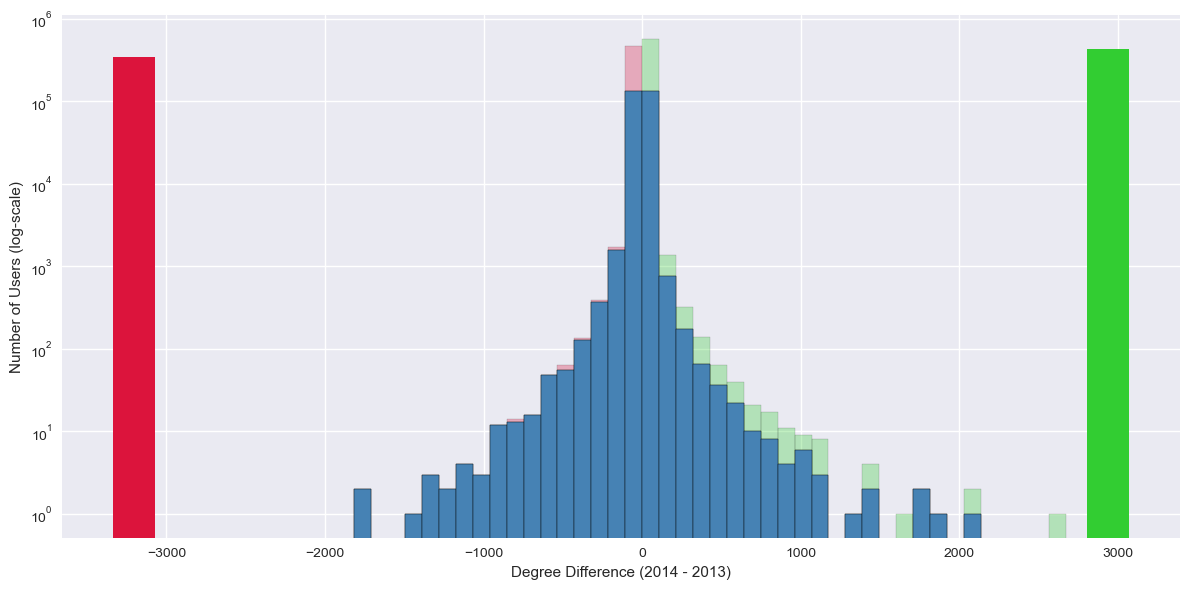

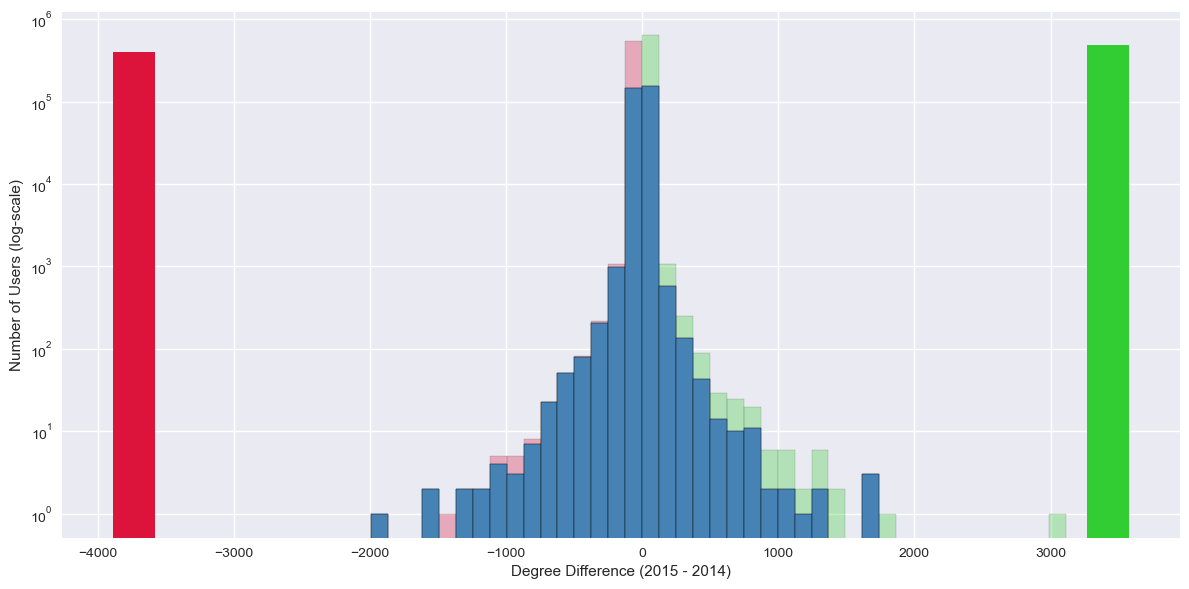

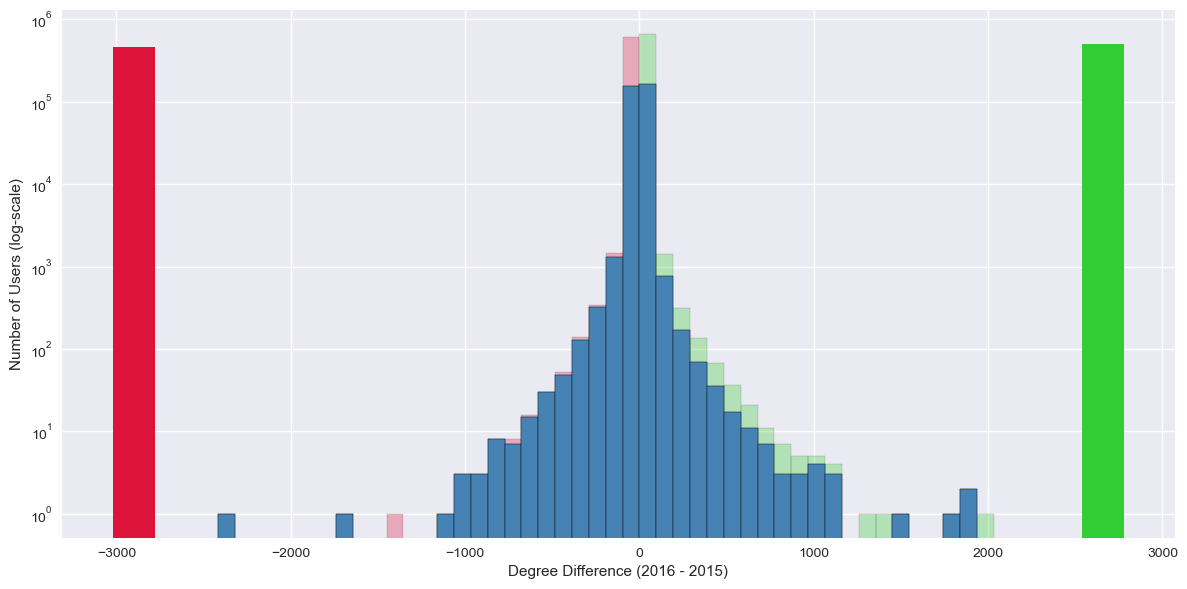

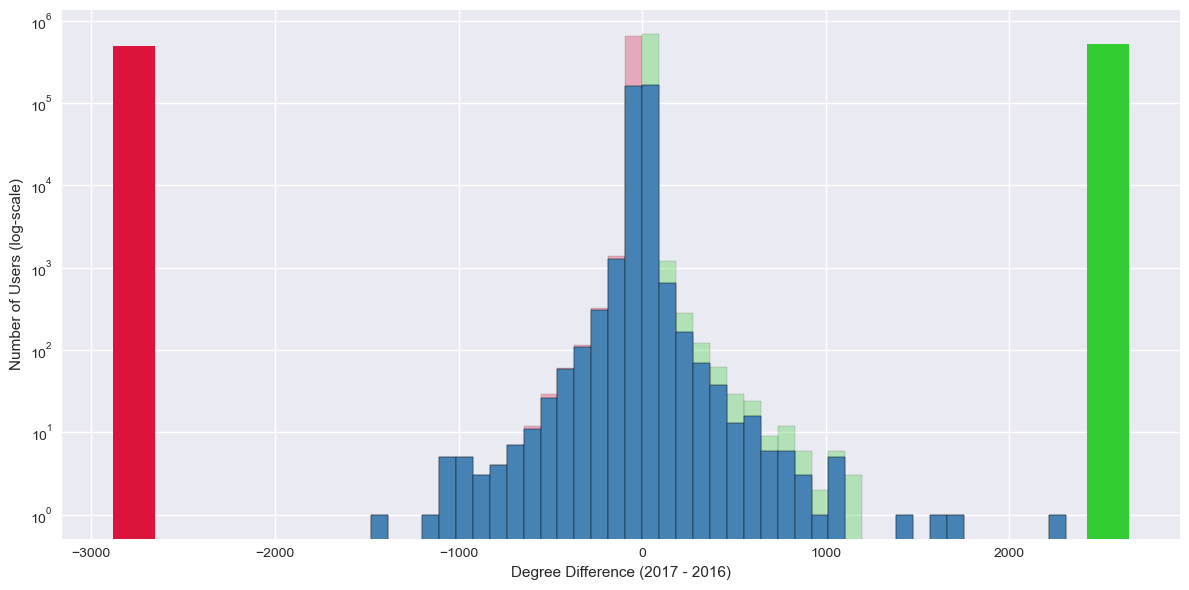

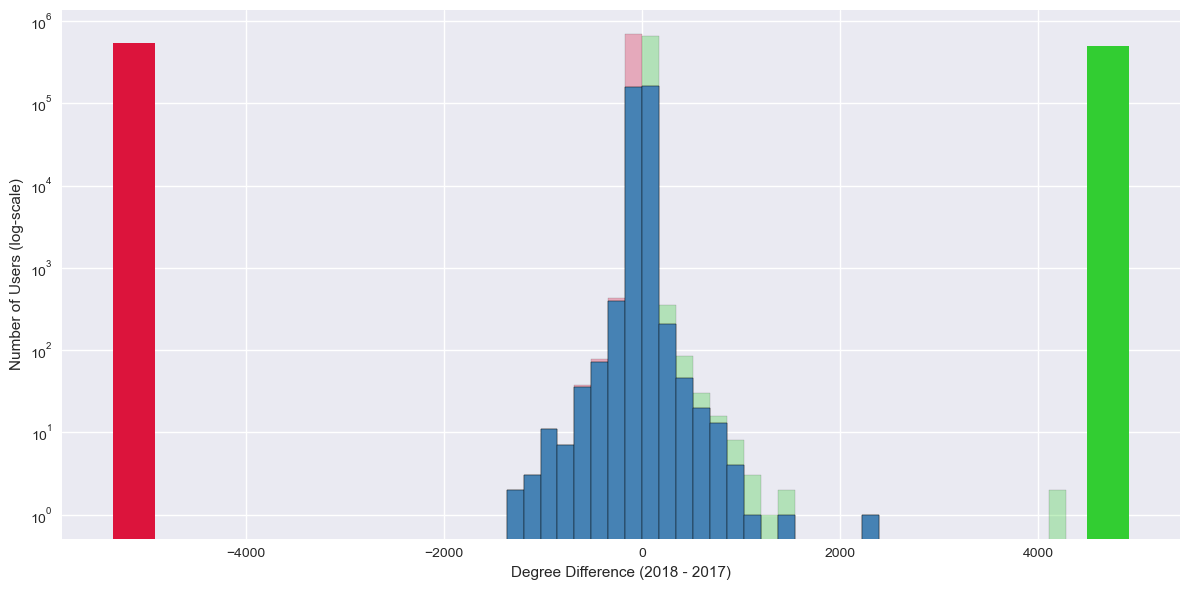

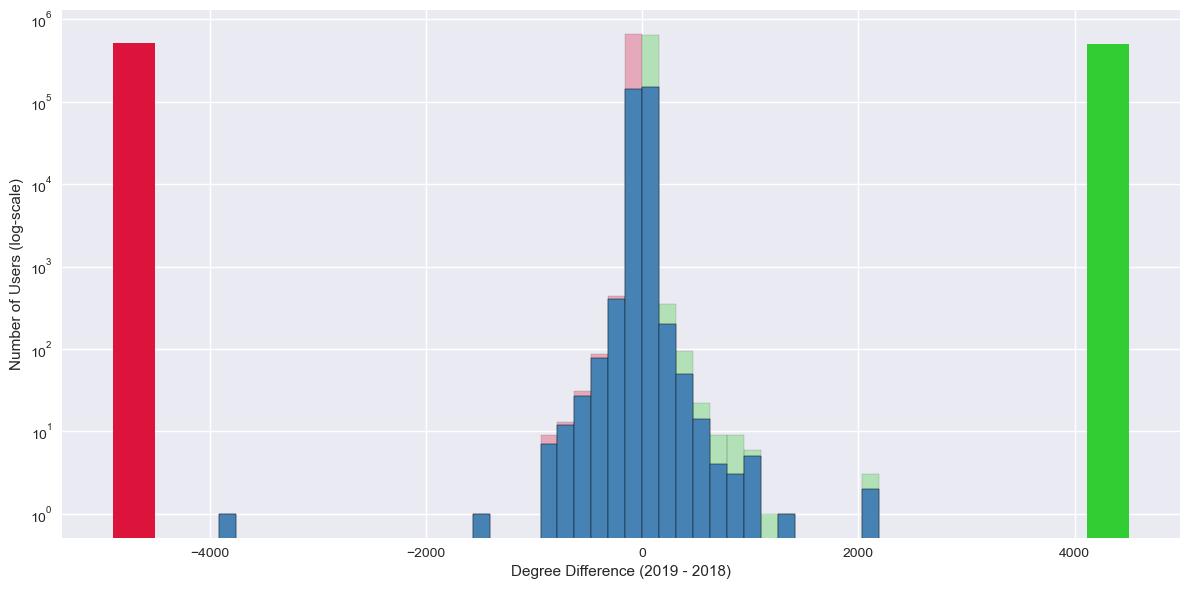

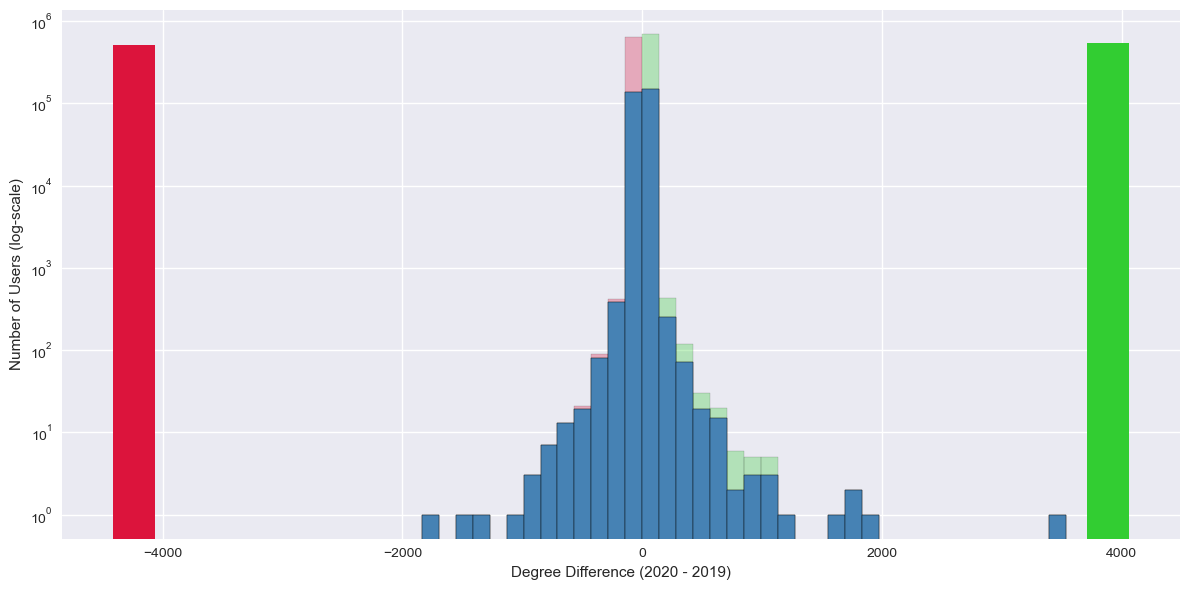

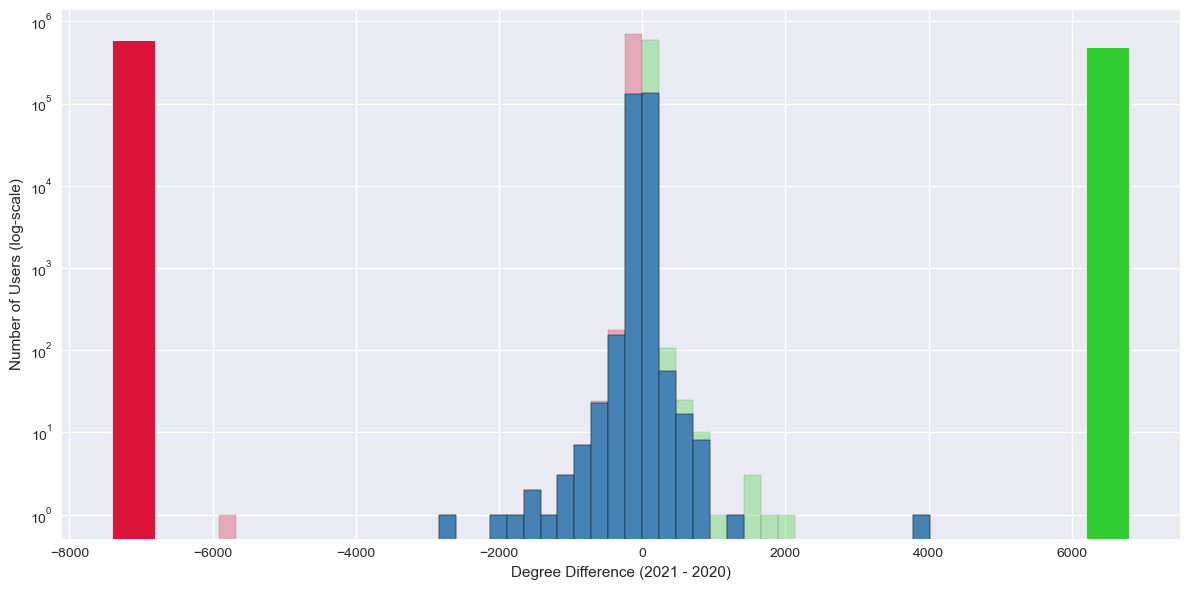

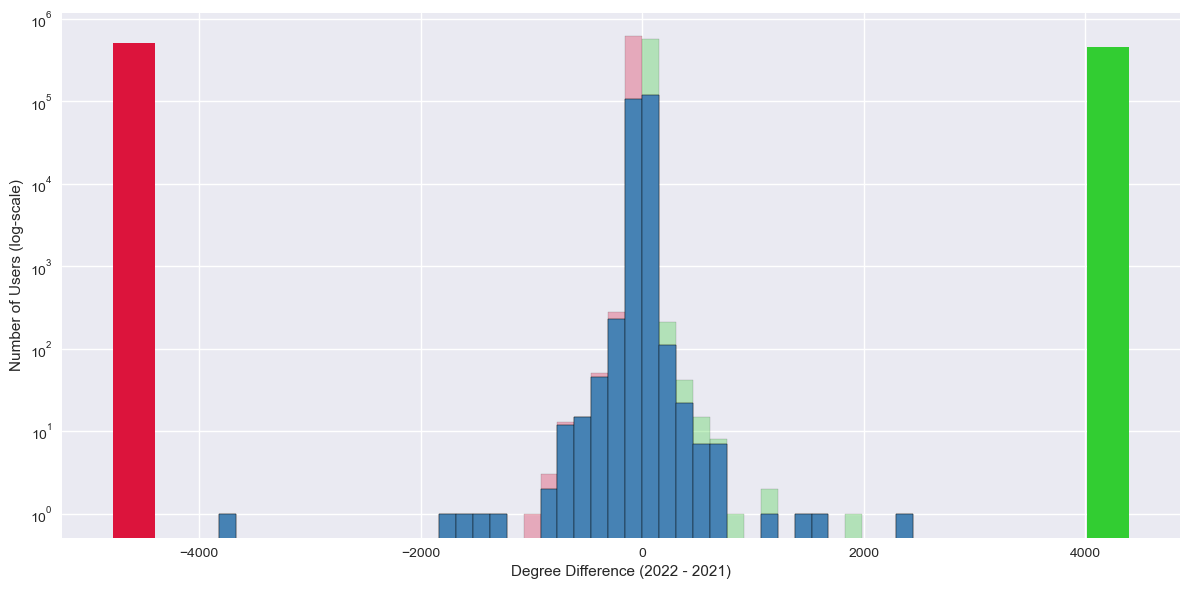

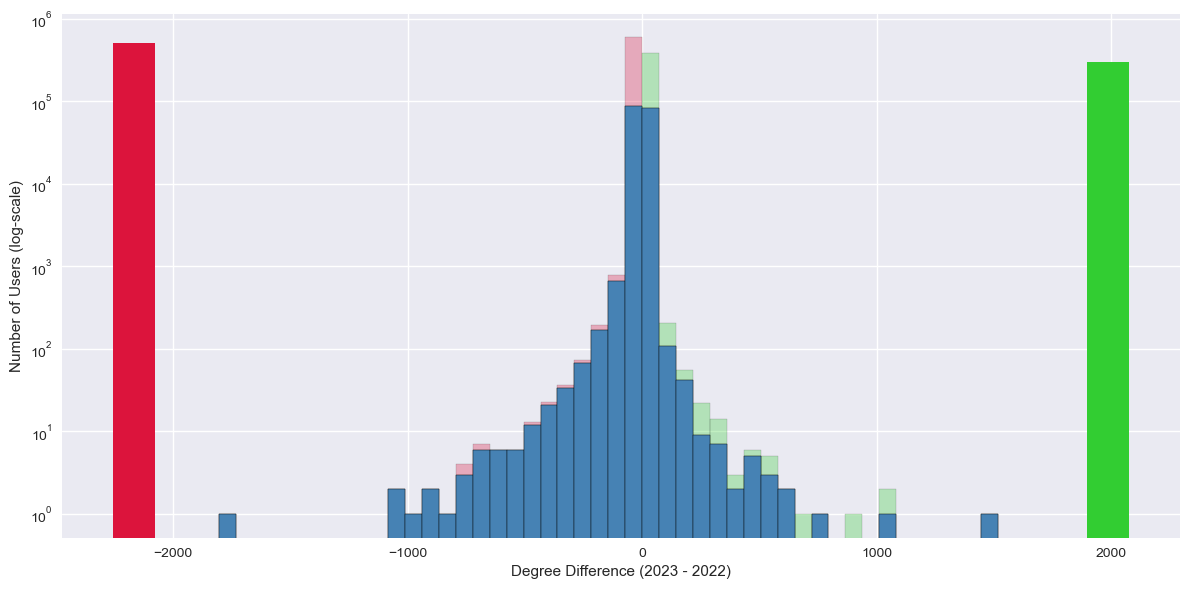

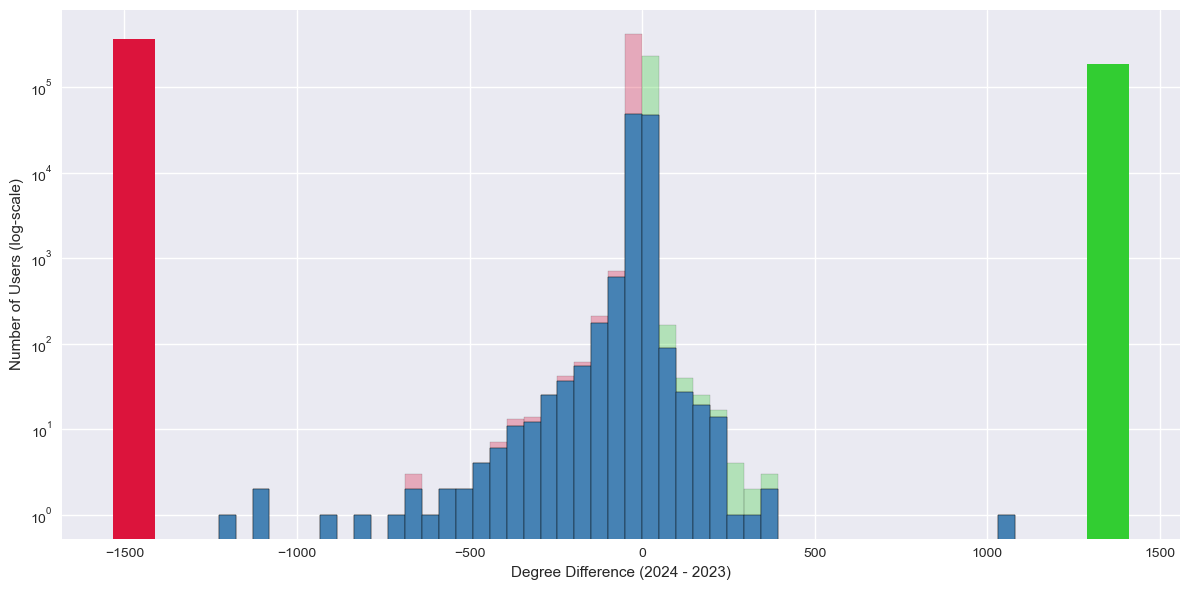

In [ ]:
"""
Get all plots and all metrics from plots.
"""

retention_ratio = []
userbase = []
userbase2 = []
g1_only = []
g2_only = []

for i in range(len(all_graphs)-1):
    val = plot_degree_diff_with_new_user_overlay(all_graphs[i], all_graphs[i+1], (2009+i, 2009+i+1), plot=False)
    retention_ratio.append(val[1] / val[0])
    userbase.append(sum(y for _, y in val[2]))
    userbase2.append(sum(y for _, y in val[3]))
    g1_only.append(val[0])
    g2_only.append(val[1])

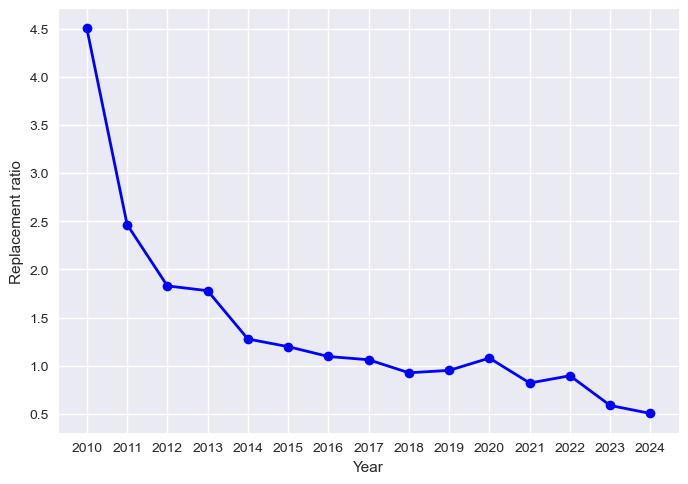

In [ ]:
"""
Replacement ratio vs time.
"""

x = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
y = retention_ratio

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Replacement ratio')

plt.xticks(x)  # ensures ticks are exactly the years you provided

plt.grid(True)
plt.show()

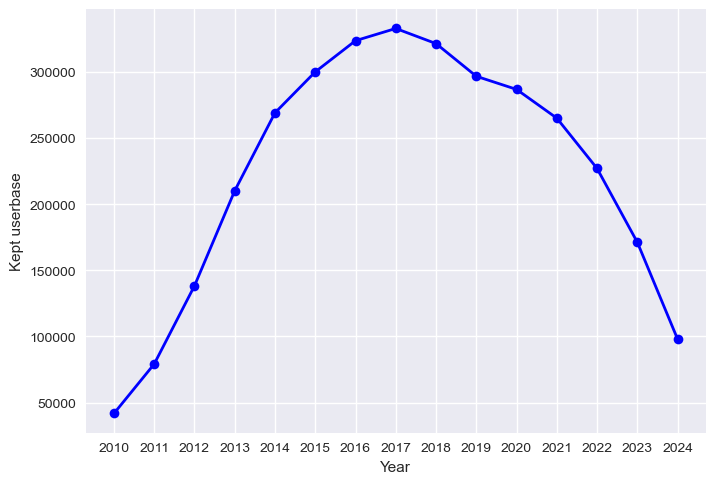

In [ ]:
"""
Kept userbase over time.
"""

x = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
y = userbase

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Kept userbase')

plt.xticks(x)

plt.grid(True)
plt.show()

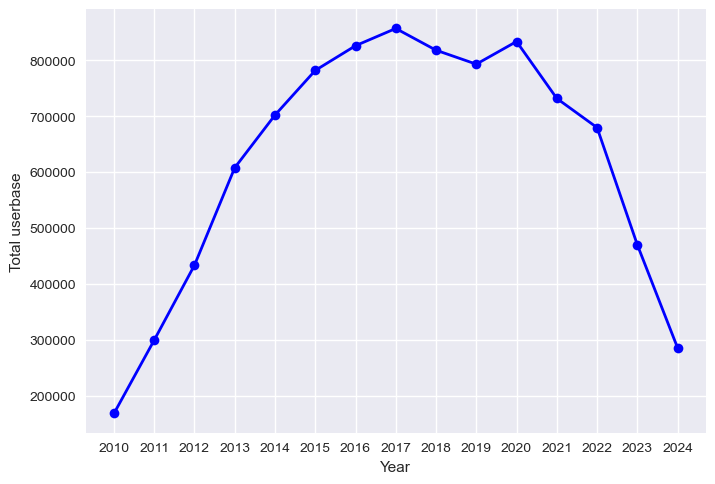

In [ ]:
"""
Total userbase over time.
"""

x = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
y = userbase2

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Total userbase')

plt.xticks(x)  # ensures ticks are exactly the years you provided

plt.grid(True)
plt.show()

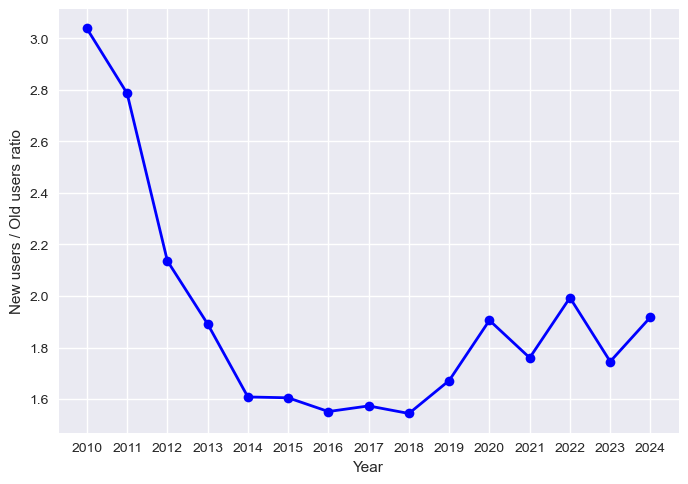

In [ ]:
"""
New users / Old users ratio over time.
"""

x = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
y = [((userbase2[i] - userbase[i]) / userbase[i]) for i in range(len(userbase))]

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('New users / Old users ratio')

plt.xticks(x)  # ensures ticks are exactly the years you provided

plt.grid(True)
plt.show()

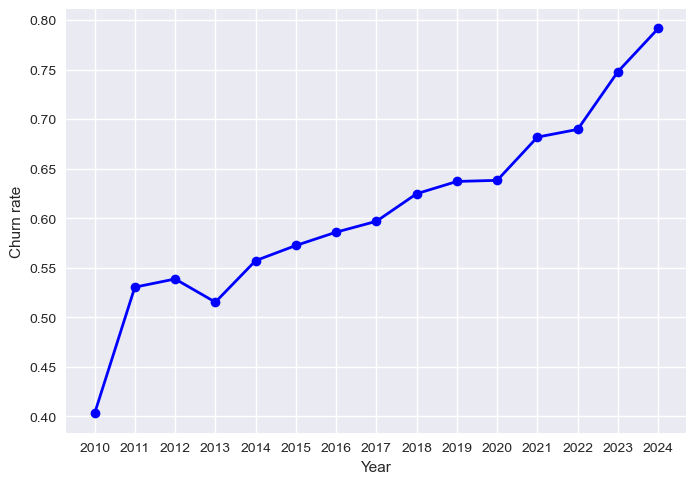

In [ ]:
"""
Churn rate over time.
"""

x = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
y = [g1_only[i] / (g1_only[i] + userbase[i]) for i in range(len(userbase))]

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Churn rate')
plt.xticks(x)  # ensures ticks are exactly the years you provided

plt.grid(True)
plt.show()

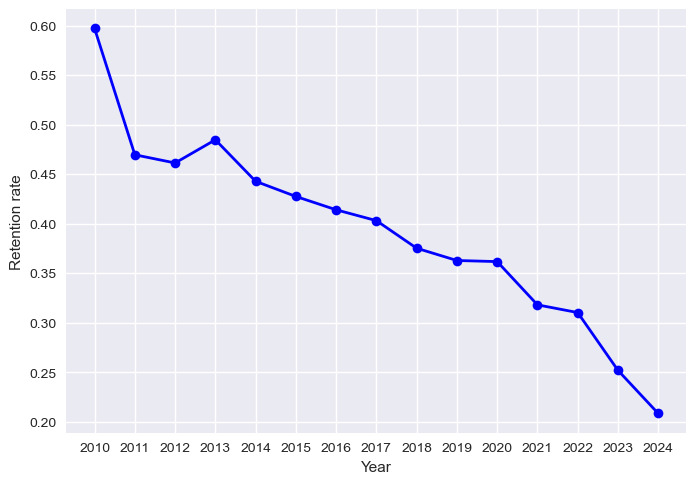

In [ ]:
"""
Retention rate over time.
"""

x = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
y = [userbase[i] / (g1_only[i] + userbase[i]) for i in range(len(userbase))]

plt.plot(x, y, marker='o', linestyle='-', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Retention rate')
plt.xticks(x)  # ensures ticks are exactly the years you provided

plt.grid(True)
plt.show()

# Questions analysis

In [ ]:
"""
Load data
"""

with open('complexity.pkl', 'rb') as f:
    df = pickle.load(f)

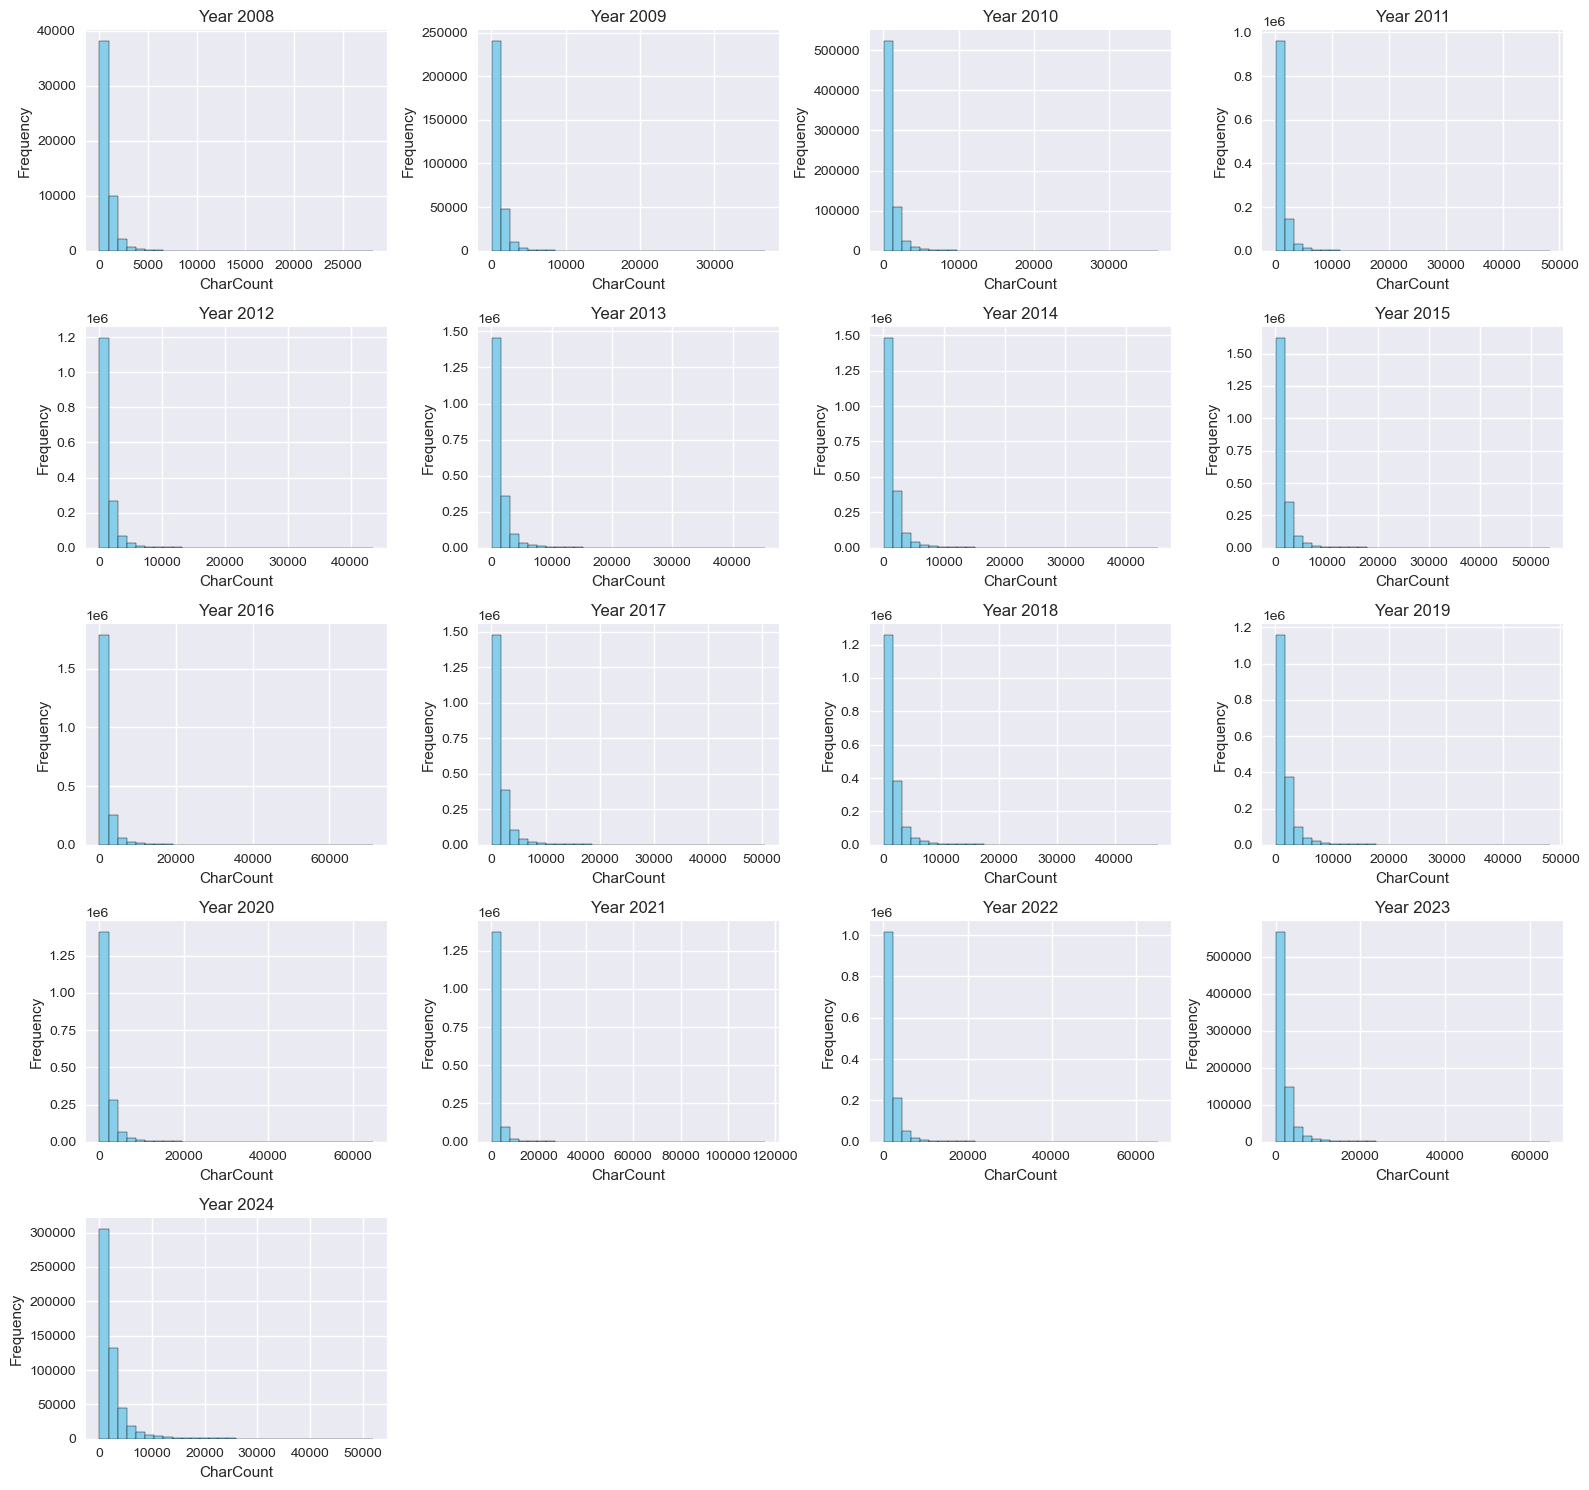

In [ ]:
"""
Plot distribution of char count over years.
"""

years = sorted(df['Year'].unique())

n_years = len(years)
n_cols = 4
n_rows = (n_years + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    year_data = df[df['Year'] == year]['CharCount']
    ax.hist(year_data, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Year {year}')
    ax.set_xlabel('CharCount')
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

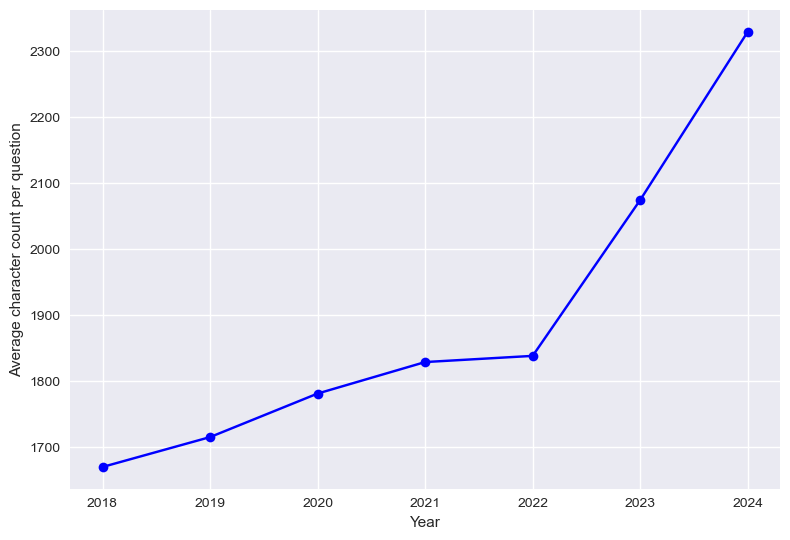

In [ ]:
"""
Average characters per question over time.
"""

yearly_avg = df.groupby('Year')['CharCount'].mean().sort_index()

plt.plot(yearly_avg[10:].index, yearly_avg[10:].values, marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Average character count per question')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# from string of tags extract list of tags
df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')

all_tags = [tag for sublist in df['Tags'] for tag in sublist]
tag_counts = Counter(all_tags)

tag_freq = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count']).sort_values('count', ascending=False)

In [ ]:
niche_tags = set(tag_freq[tag_freq['count'] < 500].index)

df['HasNicheTag'] = df['Tags'].apply(lambda tags: any(tag in niche_tags for tag in tags))

niche_by_year = df.groupby('Year')['HasNicheTag'].mean().reset_index()

avg_length = df.groupby('HasNicheTag')['CharCount'].mean()
print(avg_length)

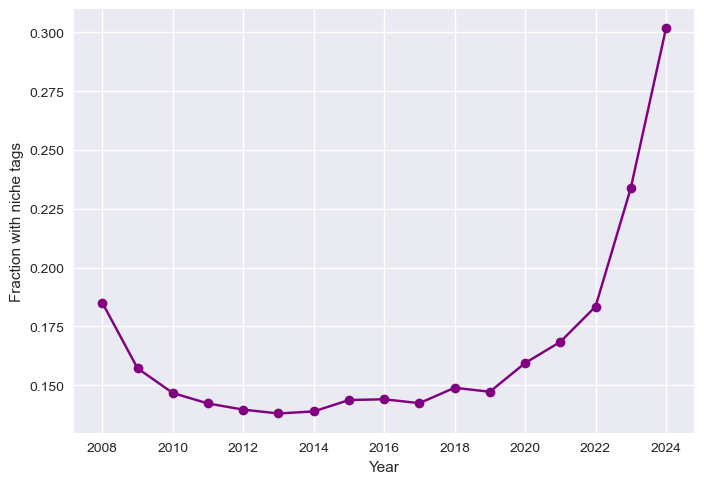

In [ ]:
"""
Questions having niche tags over time.
"""

plt.plot(niche_by_year['Year'], niche_by_year['HasNicheTag'], marker='o', color='purple')
plt.xlabel('Year')
plt.ylabel('Fraction with niche tags')
plt.grid(True)
plt.show()

In [ ]:
niche_tag_count = (tag_freq['count'] < 500).sum()
print(f"Number of niche tags: {niche_tag_count}")

total_unique_tags = len(tag_freq)
percentage_niche = (niche_tag_count / total_unique_tags) * 100

print(f"Total unique tags: {total_unique_tags}")
print(f"Percentage of niche tags: {percentage_niche:.2f}%")

Total unique tags: 65937
Percentage of niche tags: 86.91%


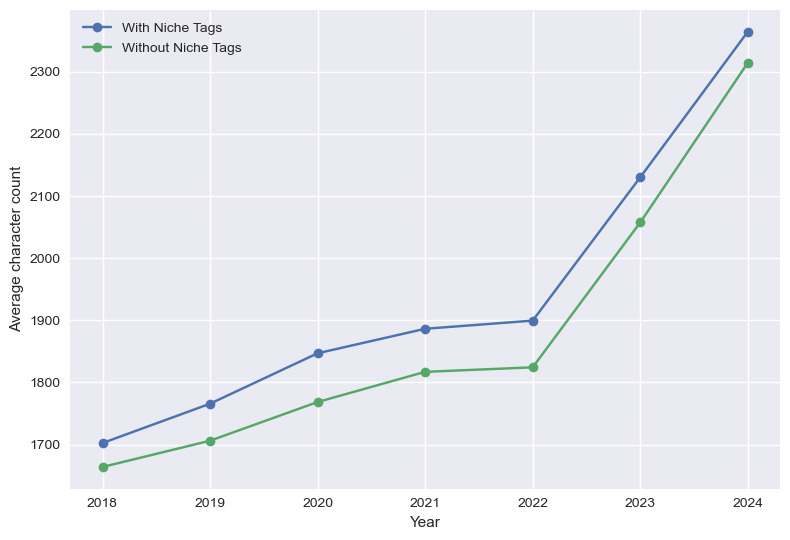

In [ ]:
"""
Average char count by year for niche and non-niche questions
"""

avg_char_by_year = df.groupby(['Year', 'HasNicheTag'])['CharCount'].mean().unstack()
avg_char_by_year = avg_char_by_year[avg_char_by_year.index >= 2018]

plt.plot(avg_char_by_year.index, avg_char_by_year[True], label='With Niche Tags', marker='o')
plt.plot(avg_char_by_year.index, avg_char_by_year[False], label='Without Niche Tags', marker='o')
plt.xlabel('Year')
plt.ylabel('Average character count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

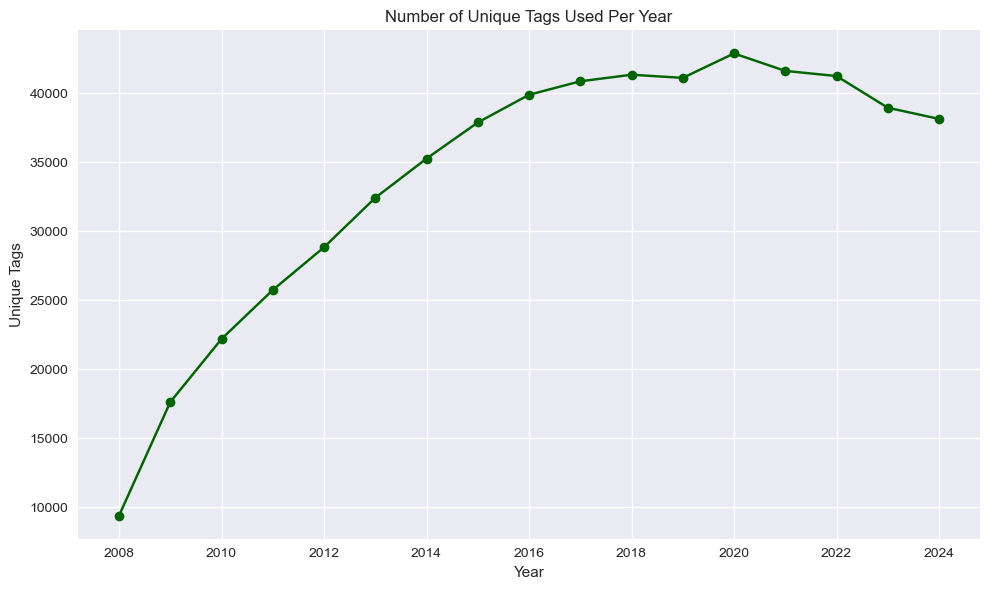

In [ ]:
"""
Number of unique tags used per year.
"""

unique_tags_per_year = df.groupby('Year')['Tags'].apply(
    lambda tag_lists: len(set(tag for tags in tag_lists for tag in tags))
).reset_index(name='UniqueTagCount')

plt.figure(figsize=(10, 6))
plt.plot(unique_tags_per_year['Year'], unique_tags_per_year['UniqueTagCount'], marker='o', color='darkgreen')
plt.title('Number of Unique Tags Used Per Year')
plt.xlabel('Year')
plt.ylabel('Unique Tags')
plt.grid(True)
plt.tight_layout()
plt.show()

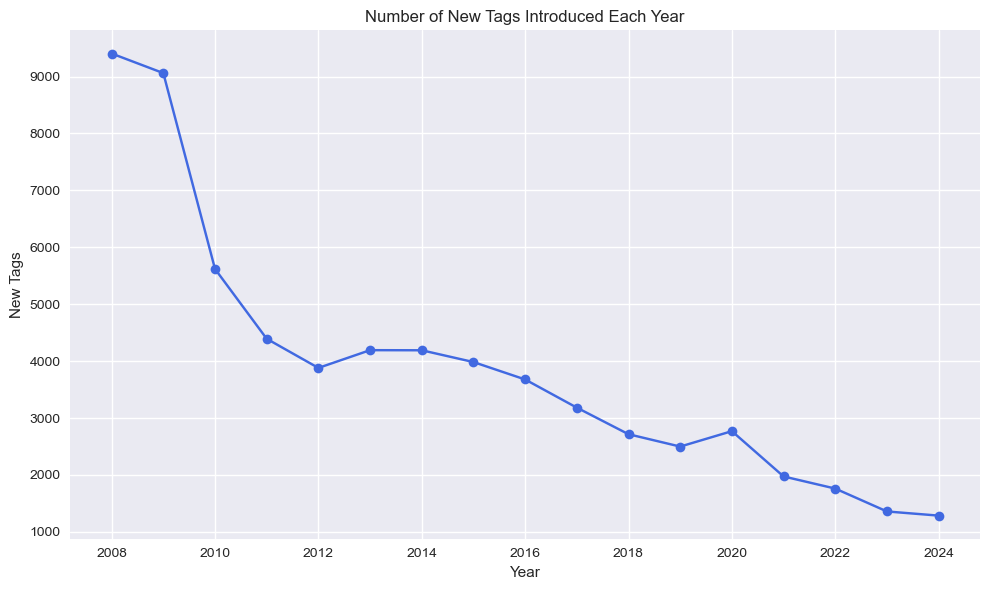

In [ ]:
"""
Number of new tags introduced each year.
"""

tag_first_year = {}

for _, row in df.iterrows():
    year = row['Year']
    for tag in row['Tags']:
        if tag not in tag_first_year:
            tag_first_year[tag] = year
        else:
            tag_first_year[tag] = min(tag_first_year[tag], year)

new_tags_by_year = Counter(tag_first_year.values())

new_tags_df = pd.DataFrame(sorted(new_tags_by_year.items()), columns=['Year', 'NewTags'])

plt.figure(figsize=(10, 6))
plt.plot(new_tags_df['Year'], new_tags_df['NewTags'], marker='o', color='royalblue')
plt.title('Number of New Tags Introduced Each Year')
plt.xlabel('Year')
plt.ylabel('New Tags')
plt.grid(True)
plt.tight_layout()
plt.show()

# Unused

## Preliminary analysis

In [ ]:
"""
Plot one-and-done users.
"""

input_file = r'D:\Download\DDMCS\Posts_light.xml'
total_size = os.path.getsize(input_file)
user_posts = defaultdict(lambda: {'questions': 0, 'total_posts': 0, 'interaction_time': None})

with open(input_file, 'rb') as f:
    tf = TqdmFile(f, total_size)
    context = etree.iterparse(tf, events=("end",), tag="row")
    
    for event, row in context:
        post_type = row.get('PostTypeId')
        user_id = row.get('OwnerUserId')
        creation_date = row.get('CreationDate')
        
        if user_id:
            user_posts[user_id]['total_posts'] += 1
            if post_type == '1':  # question
                user_posts[user_id]['questions'] += 1
                user_posts[user_id]['interaction_time'] = datetime.strptime(creation_date, "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y-%m")

        row.clear()

with open(r"D:\Download\DDMCS\dict.pkl", 'wb') as f:
    pickle.dump(dict(user_posts), f)

one_question_users = [(user_id, data['interaction_time']) for user_id, data in user_posts.items() if data['questions'] == 1 and data['total_posts'] == 1]

month_counts = defaultdict(int)
for _, date in one_question_users:
    if date:
        month_counts[date] += 1

sorted_months = sorted(month_counts.items())
months, counts = zip(*sorted_months) if sorted_months else ([], [])

plt.figure(figsize=(20, 5))
plt.scatter(months, counts, color='blue')
plt.xlabel('Month')
plt.ylabel('Number of One-Question-and-Done Users')
plt.title('Histogram of One-Question-and-Done Users by Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
with open(r"D:\Download\DDMCS\dict.pkl", "rb") as file:
    user_posts = pickle.load(file)

one_question_users = [(user_id, data['interaction_time']) for user_id, data in user_posts.items() if data['questions'] == 1 and data['total_posts'] == 1]

month_counts = defaultdict(int)
for _, date in one_question_users:
    if date:
        month_counts[date] += 1

sorted_months = sorted(month_counts.items())
months, counts = zip(*sorted_months) if sorted_months else ([], [])

user_posts['CreationDate'] = pd.to_datetime(user_posts['CreationDate'])
user_posts['Month'] = user_posts['CreationDate'].dt.to_period('M')
questions_per_month = user_posts[user_posts['PostTypeId'] == 1].groupby('Month').size()

questions_per_month.plot()
plt.title("Questions per Month on Stack Overflow")
plt.axvline(pd.to_datetime("2022-11"), color='red', linestyle='--', label='ChatGPT Launch')
plt.legend()
plt.show()

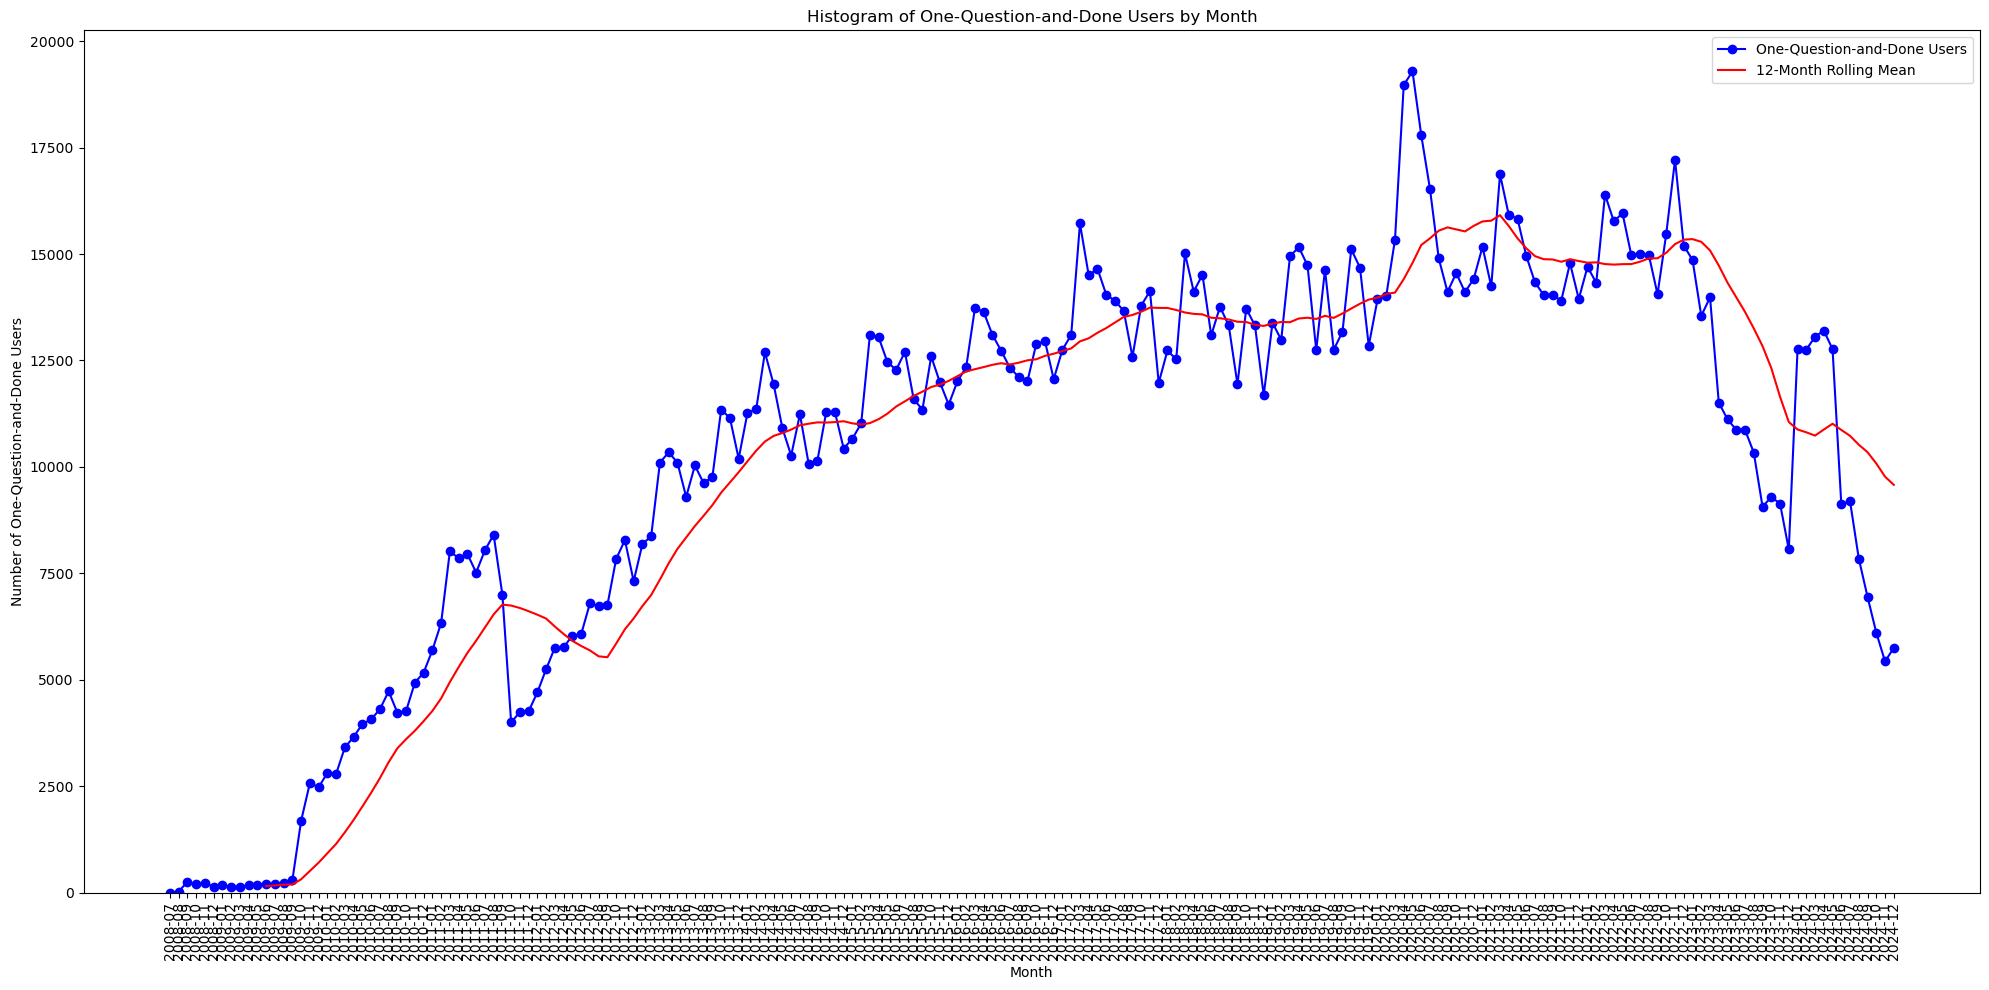

In [ ]:
data = pd.DataFrame({'Month': months, 'Count': counts})
data['RollingMean'] = data['Count'].rolling(window=12).mean()

plt.figure(figsize=(20, 10))

plt.plot(data['Month'], data['Count'], marker='o', linestyle='-', color='blue', label='One-Question-and-Done Users')
plt.plot(data['Month'], data['RollingMean'], linestyle='-', color='red', label='12-Month Rolling Mean')

plt.xlabel('Month')
plt.ylabel('Number of One-Question-and-Done Users')

plt.title('Histogram of One-Question-and-Done Users by Month')

plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
input_file = r'D:\Download\DDMCS\Posts_light.xml'
total_size = os.path.getsize(input_file)

month_counts = defaultdict(int)

with open(input_file, 'rb') as f:
    tf = TqdmFile(f, total_size)
    
    for event, row in etree.iterparse(tf, events=("end",), tag="row"):
        if int(row.get('PostTypeId')) == 1: # question
            if row.get('CreationDate'):
                post_month = datetime.strptime(row.get('CreationDate'), "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y-%m")
                month_counts[post_month] += 1

        row.clear()

with open(r"D:\Download\DDMCS\dict_posts.pkl", 'wb') as f:
    pickle.dump(dict(month_counts), f)

sorted_months = sorted(month_counts.items())
months, counts = zip(*sorted_months) if sorted_months else ([], [])

plt.figure(figsize=(20, 5))
plt.scatter(months, counts, color='blue')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.title('Histogram of Posts per Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
with open(r"D:\Download\DDMCS\dict.pkl", "rb") as file:
    user_posts = pickle.load(file)

with open(r"D:\Download\DDMCS\dict_posts.pkl", "rb") as file:
    month_posts = pickle.load(file)

one_question_users = [(user_id, data['interaction_time']) for user_id, data in user_posts.items() if data['questions'] == 1 and data['total_posts'] == 1]

month_counts = defaultdict(int)
for _, date in one_question_users:
    if date:
        month_counts[date] += 1

sorted_months = sorted(month_counts.items())
months, counts = zip(*sorted_months) if sorted_months else ([], [])

counts = list(counts)

for i in range(len(counts)):
    counts[i] = counts[i] / month_posts[months[i]]

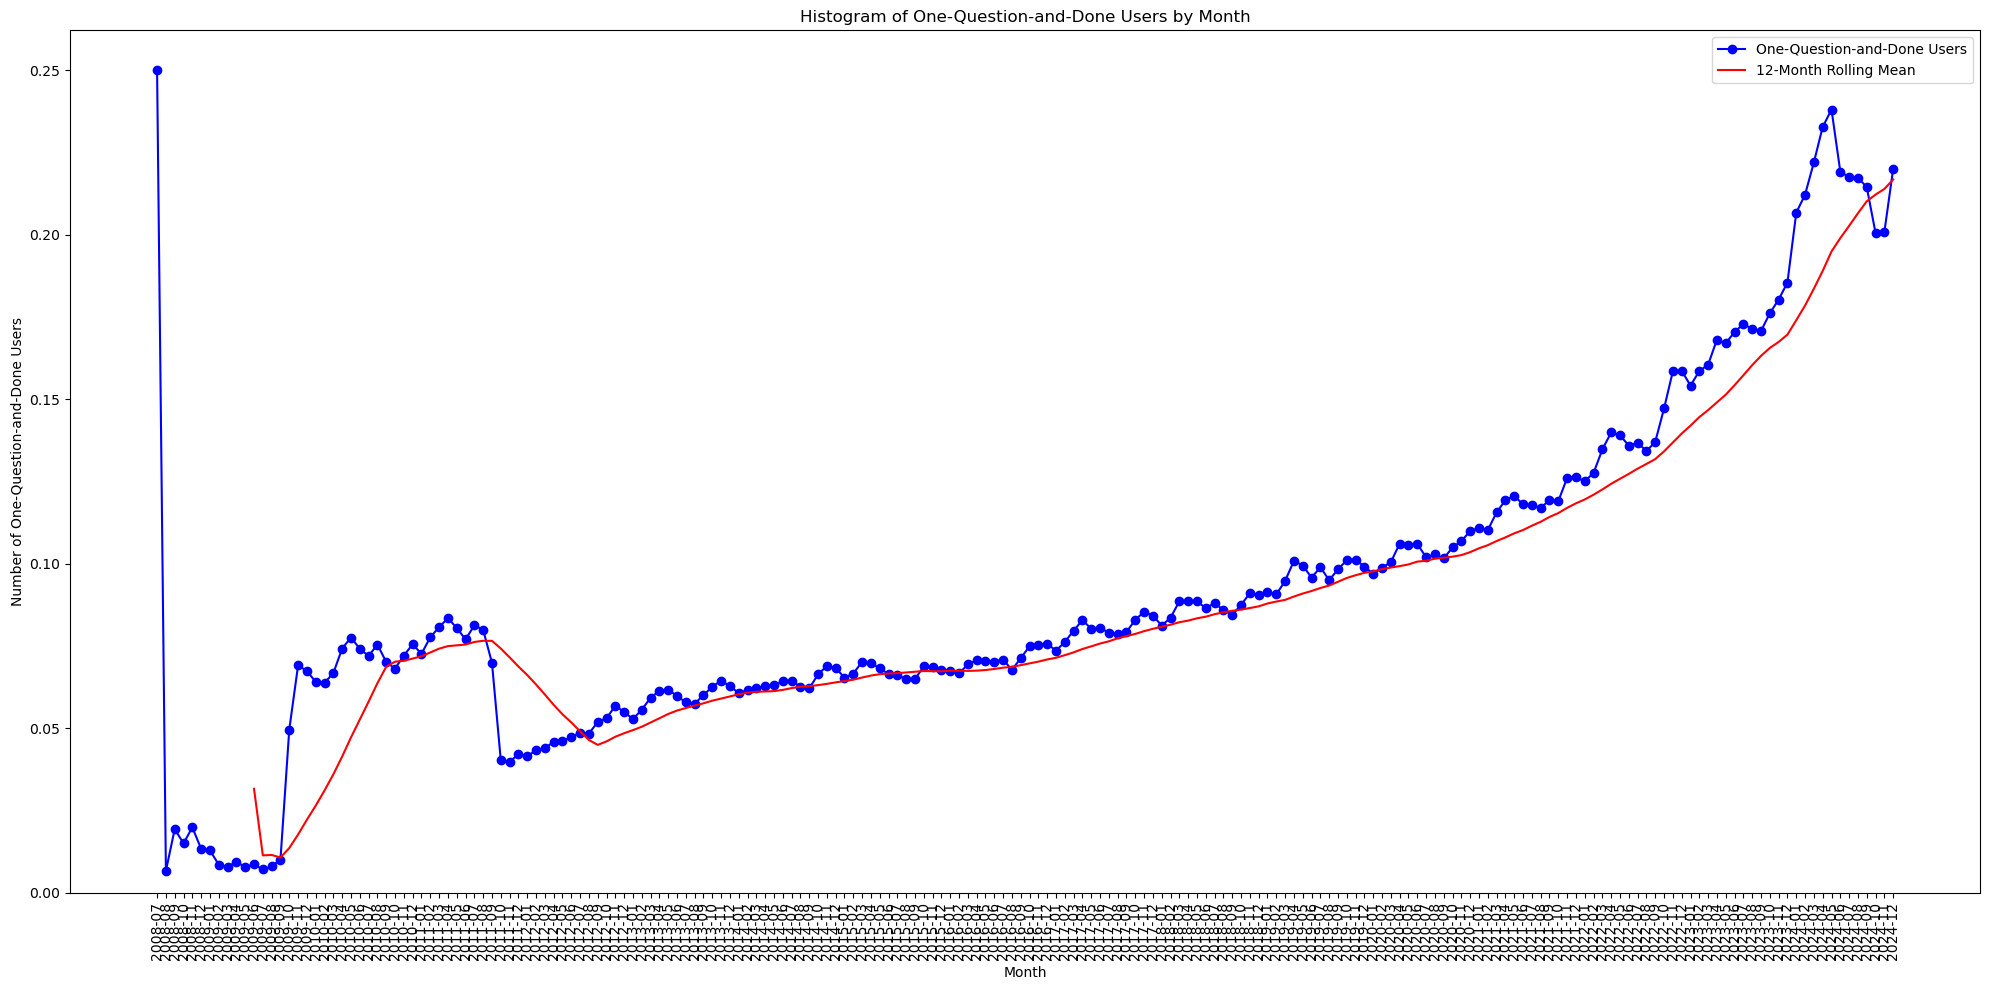

In [ ]:
data = pd.DataFrame({'Month': months, 'Count': counts})
data['RollingMean'] = data['Count'].rolling(window=12).mean()

plt.figure(figsize=(20, 10))
plt.plot(data['Month'], data['Count'], marker='o', linestyle='-', color='blue', label='One-Question-and-Done Users')
plt.plot(data['Month'], data['RollingMean'], linestyle='-', color='red', label='12-Month Rolling Mean')

plt.xlabel('Month')
plt.ylabel('Number of One-Question-and-Done Users')
plt.title('Histogram of One-Question-and-Done Users by Month')

plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()

plt.show()

## Tags improvement

In [ ]:
tag_year_counts = defaultdict(int)

for _, row in df.iterrows():
    year = row['Year']
    for tag in row['Tags']:
        tag_year_counts[(tag, year)] += 1

tag_year_df = pd.DataFrame(
    [(tag, year, count) for (tag, year), count in tag_year_counts.items()],
    columns=['Tag', 'Year', 'Count'])

In [ ]:
tag_pivot = tag_year_df.pivot(index='Tag', columns='Year', values='Count').fillna(0)

slopes = {}

for tag, row in tag_pivot.iterrows():
    years = row.index.values
    counts = row.values[14:]

    slope, _, _, _, _ = linregress(years, counts)
    slopes[tag] = slope


slope_df = pd.DataFrame.from_dict(slopes, orient='index', columns=['slope'])
growing_tags = slope_df[slope_df['slope'] > 0].sort_values('slope', ascending=False)
print(growing_tags.head(100))

               slope
maui           947.9
next.js        758.7
vite           659.7
next.js13      497.8
langchain      454.4
...              ...
python-3.11     53.0
spring-boot-3   52.7
ios17           52.5
neovim          52.2
angular15       52.1

[100 rows x 1 columns]


In [ ]:
tag_trends = tag_year_df.pivot(index='Tag', columns='Year', values='Count').fillna(0)

recent_years = [2022, 2023, 2024]
available_years = [y for y in recent_years if y in tag_trends.columns]

tag_trends['Post2022_Avg'] = tag_trends[available_years[1:]].mean(axis=1)
tag_trends['GainSince2022'] = tag_trends['Post2022_Avg'] - tag_trends.get(2022, 0)

top_gainers = tag_trends.sort_values('GainSince2022', ascending=False)
print(top_gainers[['GainSince2022']].head(100))


Year                     GainSince2022
Tag                                   
next.js13                       1497.0
maui                            1279.5
openai-api                      1132.5
langchain                       1090.5
large-language-model             890.0
...                                ...
gradio                            91.0
maui-community-toolkit            91.0
swiftui-navigationstack           90.5
drizzle                           90.5
node.js-fs                        90.5

[100 rows x 1 columns]


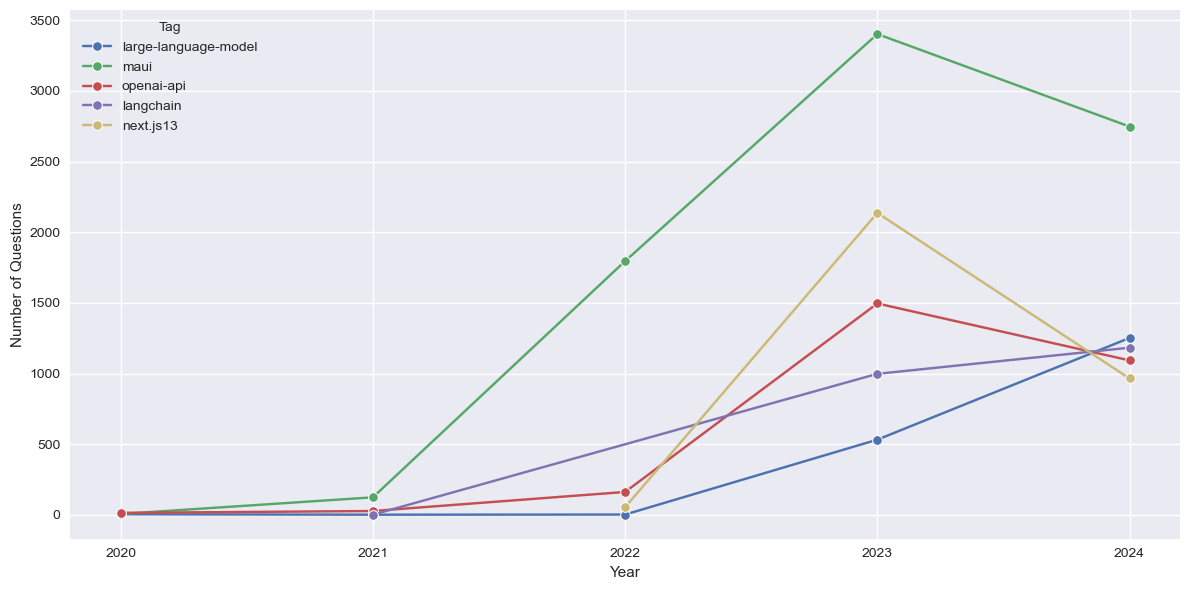

In [ ]:
top_tags = top_gainers.head(5).index

subset = tag_year_df[(tag_year_df['Tag'].isin(top_tags)) & 
    (tag_year_df['Year'] >= 2020)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=subset, x='Year', y='Count', hue='Tag', marker='o')
plt.xticks(ticks=[2020, 2021, 2022, 2023, 2024])
plt.ylabel('Number of Questions')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

## Tags and communities correlation, question projection

In [ ]:
with open('bipartite_2024.pkl', 'rb') as f:
    graph = pickle.load(f)

users = {n for n, d in graph.nodes(data=True) if d['bipartite'] == 'user'}
user_projection = bipartite.projected_graph(graph, users)

questions = set(graph) - users
question_projection = bipartite.projected_graph(graph, questions)

partition = community_louvain.best_partition(question_projection)

with open('communities.pkl', 'wb') as f:
    pickle.dump(partition, f)

In [ ]:
with open('communities.pkl', 'rb') as f:
    partition = pickle.load(f)

df_questions = all_data[-1][all_data[-1]["PostTypeId"] == "1"]

In [ ]:
df_questions['qst_id'] = 'qst_' + df_questions['Id'].astype(str)
df_questions['community'] = df_questions['qst_id'].map(partition)

df_questions = df_questions.dropna(subset=['community'])

df_questions['Tags'] = df_questions['Tags'].fillna('')
df_questions['tag_list'] = df_questions['Tags'].str.findall(r'<(.*?)>')

mlb = MultiLabelBinarizer(sparse_output=True)
tag_matrix_sparse = mlb.fit_transform(df_questions['tag_list'])

tag_df_sparse = pd.DataFrame.sparse.from_spmatrix(tag_matrix_sparse, columns=mlb.classes_)
tag_df_sparse['community'] = df_questions['community'].values

community_tag_matrix_sparse = tag_df_sparse.groupby('community').sum()

C:\Users\Utente\AppData\Local\Temp\ipykernel_14548\2385684139.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_questions['qst_id'] = 'qst_' + df_questions['Id'].astype(str)
C:\Users\Utente\AppData\Local\Temp\ipykernel_14548\2385684139.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_questions['community'] = df_questions['qst_id'].map(partition)


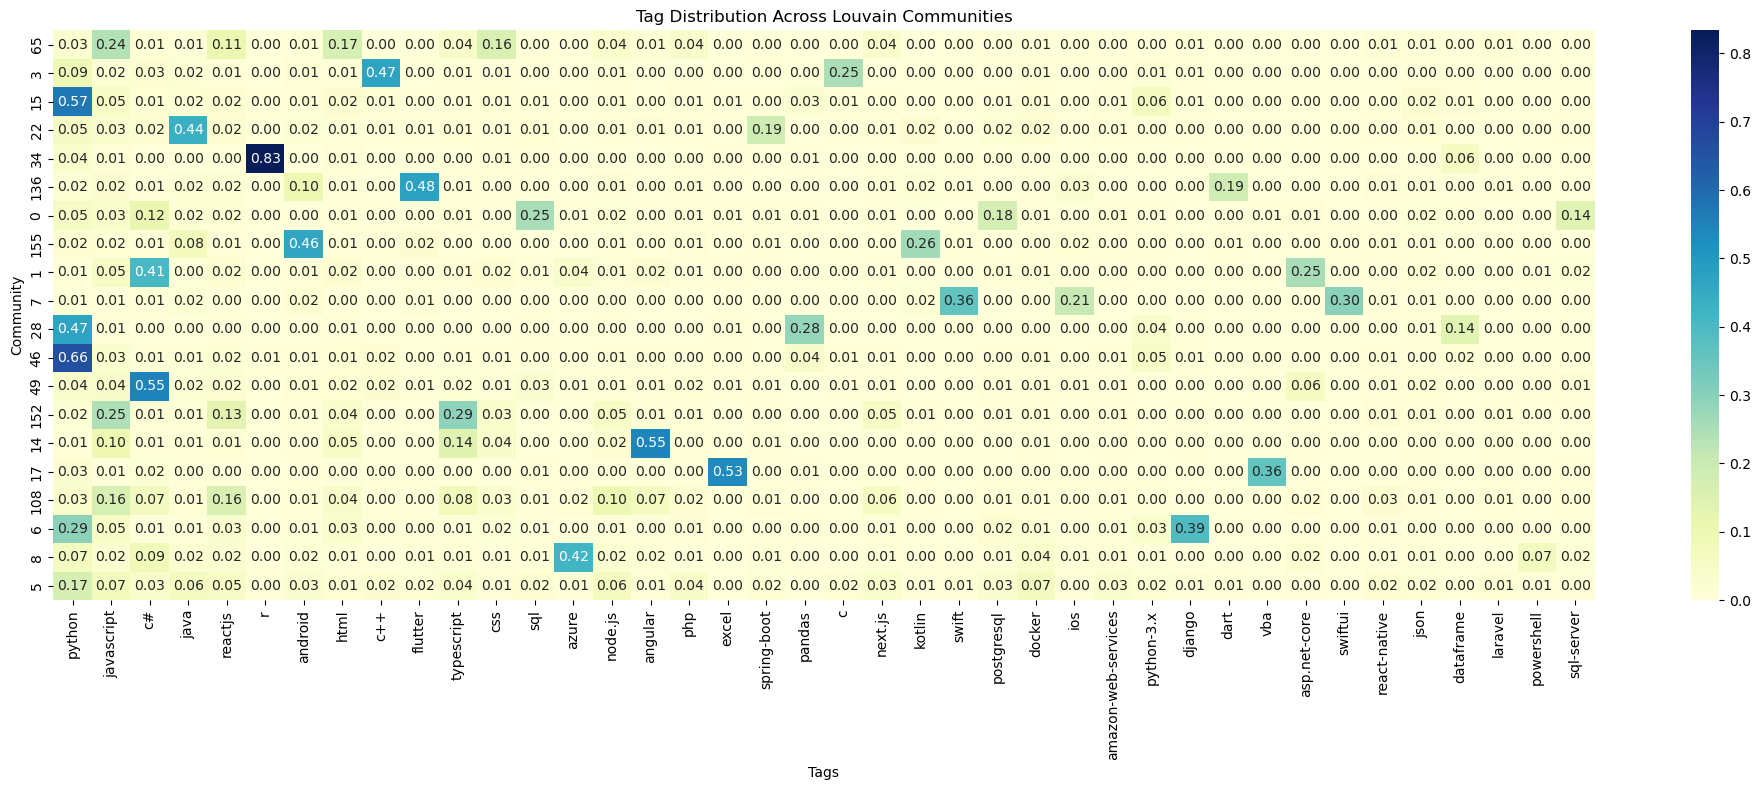

In [ ]:
top_communities = community_tag_matrix_sparse.sum(axis=1).sort_values(ascending=False).head(20).index
top_tags = community_tag_matrix_sparse.sum().sort_values(ascending=False).head(30).index

plot_data = community_tag_matrix_sparse.loc[top_communities, top_tags].astype(float)
plot_data.index = plot_data.index.astype(int)

plt.figure(figsize=(20, 8))
sns.heatmap(plot_data.div(plot_data.sum(axis=1), axis=0), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Tag Distribution Across Louvain Communities")
plt.xlabel("Tags")
plt.ylabel("Community")
plt.tight_layout()
plt.show()

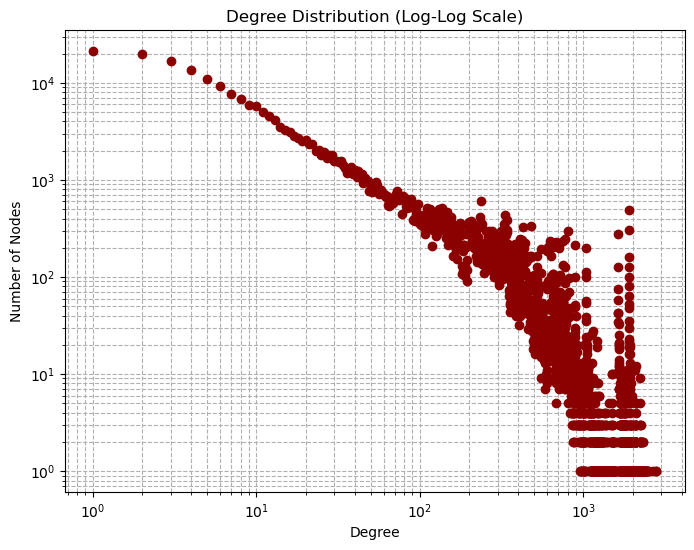

In [ ]:
degrees = [degree for _, degree in question_projection.degree()]

degree_count = {}
for deg in degrees:
    degree_count[deg] = degree_count.get(deg, 0) + 1

deg, cnt = zip(*sorted(degree_count.items()))

plt.figure(figsize=(8, 6))
plt.loglog(deg, cnt, marker='o', linestyle='None', color='darkred')
plt.title("Degree Distribution (Log-Log Scale)")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.show()